<h1 style="color:blue;"> Predicting Driver Attrition </h1>

# Business Problem:

Recruiting and retaining drivers is seen by industry watchers as a tough battle for a ride-sharing company. Churn among drivers is high and it’s very easy for drivers to stop working for the company on the fly or jump to their competition depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, a ride-sharing company is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

This case study is focused on driver team attrition. We are provided with the monthly information for a segment of drivers for 2019 and 2020 and the task is to predict whether a driver will be leaving the company or not based on a given set of attributes.

# Importing Libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
from prettytable import PrettyTable
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

!pip install -q imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

!pip install -q category_encoders
import category_encoders as ce

     |████████████████████████████████| 80 kB 3.2 MB/s 


# Understanding the Data

## Quick Look at the data

__Loading the Data__

In [2]:
data_path = 'data.csv'
df = pd.read_csv(data_path)

__Data Dimension__

In [3]:
df.shape

(19104, 14)

__Summary:__

We have 19104 data points, and 14 features

__How the data looks like?__

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


__Column names:__

In [5]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

**We have following informations about the columns:**
<ol>
<li>MMMM-YY : Reporting Date (Monthly)</li>
<li>Driver_ID : Unique id for drivers</li>
<li>Age : Age of the driver</li>
<li>Gender : Gender of the driver – Male : 0, Female: 1</li>
<li>City : City Code of the driver</li>
<li>Education_Level : Education level –  0 for 10+ ,1 for 12+ ,2 for graduate</li>
<li>Income : Monthly average Income of the driver</li>
<li>Date Of Joining : Joining date for the driver</li>
<li>LastWorkingDate : Last date of working for the driver</li>
<li>Joining Designation : Designation of the driver at the time of joining</li>
<li>Grade : Grade of the driver at the time of reporting</li>
<li>Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)</li>
<li>Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)</li>
</ol>

__Checking the data types of the columns__

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


__Summary__

- We have following types of attributes: `float`, `int`, and `object`
- We also have an index column. So we will drop it

In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Some basic checks


### Checking duplicate rows

In [8]:
duplicate = df[df.duplicated(keep = 'last')]
duplicate

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating


__Findings:__
- There are no duplicate rows in the dataset

### Fixing any discrepansies in dtype

In [9]:
def iqr(x):
    return x.quantile(q=0.75) - x.quantile(q=0.25)

def quantile_boundaries(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)
    return (lower_out, upper_out)

## Outlier > 75th %tile + 1.5IQR & < 25th %tile - 1.5IQR
def outlier_count(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)

    return len(x[x > upper_out]) + len(x[x < lower_out])

In [10]:
def stats_summary(df, type):
    """
    Method to display statistical summaries for categorical and numerical columns

    Arguments:
        df: a data frame object
        type: the dtype for which summaries will be computed.
            Accepts two values: either 'numeric' or 'category'

    Returns:
        A dataframe object containing statistical summaries
    """
    if type=='numeric':
        df_num = df._get_numeric_data()
        df_stats = df_num.describe().T
        try:
            vals = []
            unique = []
            for c in df_num.columns:
                vals.append(outlier_count(df_num[c]))
                unique.append(df_num[c].nunique())
            df_stats['Count of Outliers'] = vals
            df_stats['Unique Values'] = unique
        except:
            pass
        return df_stats

    elif type=='category':
        df_cat = df.select_dtypes(['category'])
        df_stats = df_cat.describe().T

        try:
            vals = []
            for c in df_cat.columns:
                vals.append((df_cat[df_cat[c].isnull()].shape[0]*100) / df_cat.shape[0])
            df_stats['Missing Percentage'] = vals
        except:
            pass
        return df_stats

    else:
        raise Exception('Legal type params are {"numeric", "category"}') 

In [11]:
def datatype_conversion(df, columns, target_type):
    """
    Method to convert the type of columns in "columns" to "target_type"
    """
    convert_dict = dict(zip(columns, [target_type]*len(columns)))
    df = df.astype(convert_dict)
    return df

def datatype_information(df):
    """
    Method to display "dtype" for each column
    """
    datatype_info = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        datatype_info.loc[0, col] = df[col].dtype
    return datatype_info

#### numbers

In [12]:
df.select_dtypes([np.number]).head()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,2,57387,1,1,2381060,2
1,1,28.0,0.0,2,57387,1,1,-665480,2
2,1,28.0,0.0,2,57387,1,1,0,2
3,2,31.0,0.0,2,67016,2,2,0,1
4,2,31.0,0.0,2,67016,2,2,0,1


In [13]:
stats_summary(df, 'numeric')

,count,mean,std,min,25%,50%,75%,max,Count of Outliers,Unique Values
Driver_ID,19104.0,1415.591133,8.107053e+02,1.0,710.0,1417.0,2137.0,2788.0,0,2381
Age,19043.0,34.668435,6.257912e+00,21.0,30.0,34.0,39.0,58.0,78,36
Gender,19052.0,0.418749,4.933670e-01,0.0,0.0,0.0,1.0,1.0,0,2
Education_Level,19104.0,1.021671,8.001671e-01,0.0,0.0,1.0,2.0,2.0,0,3
Income,19104.0,65652.025126,3.091452e+04,10747.0,42383.0,60087.0,83969.0,188418.0,188,2383
Joining Designation,19104.0,1.690536,8.369837e-01,1.0,1.0,1.0,2.0,5.0,471,5
Grade,19104.0,2.252670,1.026512e+00,1.0,1.0,2.0,3.0,5.0,0,5
Total Business Value,19104.0,571662.074958,1.128312e+06,-6000000.0,0.0,250000.0,699700.0,33747720.0,1371,10181
Quarterly Rating,19104.0,2.008899,1.009832e+00,1.0,1.0,2.0,3.0,4.0,0,4


__Findings:__
- The unique values count for the attribute "Gender", "Education_Level", "Job Designation", "Grade", and "Quarterly Rating" are less. We can treat them as categorical.
- Count of "Driver_ID" is not equal to total number of data points. This suggest we have multiple reports for a Driver. 

__Fixing the dtype:__

In [14]:
df = datatype_conversion(df, ["Gender", "Education_Level", "Joining Designation", "Grade", "Quarterly Rating"], 'category')
datatype_information(df)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,object,int64,float64,category,object,category,int64,object,object,category,category,int64,category


__Summary__

- We fixed the incorrect datatypes

#### object

In [15]:
df.select_dtypes('object').head(3)

,MMM-YY,City,Dateofjoining,LastWorkingDate
0,01/01/19,C23,24/12/18,NaN
1,02/01/19,C23,24/12/18,NaN
2,03/01/19,C23,24/12/18,03/11/19


In [16]:
df.describe(include='object')

,MMM-YY,City,Dateofjoining,LastWorkingDate
count,19104,19104,19104,1616
unique,24,29,869,493
top,01/01/19,C20,23/07/15,29/07/20
freq,1022,1008,192,70


__Findings:__
- We can treat "City" as categorical.
- "MMM-YY" and "Dateofjoining" are date columns.

__Fixing the dtype:__

In [17]:
df = datatype_conversion(df, ["City" ], 'category')
datatype_information(df)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,object,int64,float64,category,category,category,int64,object,object,category,category,int64,category


In [18]:
df = datatype_conversion(df, ["MMM-YY", "Dateofjoining", "LastWorkingDate"], 'datetime64')
datatype_information(df)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,datetime64[ns],int64,float64,category,category,category,int64,datetime64[ns],datetime64[ns],category,category,int64,category


__Summary__

- We fixed the incorrect datatypes

### Checking missing values

In [19]:
def missing_val_overview(df):

    ## Creating Empty Data Frame
    data_info = pd.DataFrame(np.random.randn(0, 5) * 0,
                             columns=['No. of Rows with missing values',
                                      'No. of columns with zero missing cases',
                                      'No. of columns with >0 and <=50% missing cases',
                                      'No. of columns with >50% missing cases',
                                      'No. of columns with >90% missing cases'])

    ## Data Inofrmation
    data_info.loc[0, 'No. of Rows with missing values'] = df.isna().any(axis=1).sum()
    null_per = pd.DataFrame(df.isna().sum()/df.shape[0])
    null_per.columns = ['null_per']
    data_info.loc[0, 'No. of columns with zero missing cases']  = null_per[null_per.null_per == 0.0].shape[0] 
    data_info.loc[0, 'No. of columns with >0 and <=50% missing cases'] = null_per[(null_per.null_per <= 0.50) & (null_per.null_per > 0)].shape[0] 
    data_info.loc[0, 'No. of columns with >50% missing cases']  = null_per[null_per.null_per > 0.50].shape[0]
    data_info.loc[0, 'No. of columns with >90% missing cases']  = null_per[null_per.null_per > 0.90].shape[0]
    
    ## Transposing Data to get in consumable format
    data_info = data_info.transpose()
    data_info.columns = ['Value']
    data_info['Value'] = data_info['Value'].astype(int)

    return data_info

In [20]:
missing_val_overview(df)

,Value
No. of Rows with missing values,17498
No. of columns with zero missing cases,10
No. of columns with >0 and <=50% missing cases,2
No. of columns with >50% missing cases,1
No. of columns with >90% missing cases,1


**Summary**
- There are missing values in 3 columns

In [21]:
df.isnull().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

__Findings:__
- There is missing values for numerical, categorical, and as well as object columns.
- We will employ different strategies to impute/clean them.

# EDA

We did some surface scratching and found some basic details. Now we will do in depth exploration of the dataset and try to come up with some possible actionable insights.

### Aggregation of Driver details:

One thing to note is that, there are multiples reports available for a Driver:

In [22]:
df[df['Driver_ID'] == 1]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2


As the task at hand is for driver team attrition, ie to predict whether a driver will be leaving the company or not based on some given attributes, we will first remove these multiple occurences by aggregating the attributes based on "Driver_ID".

In [23]:
driver_agg_dict = {
    'MMM-YY': 'last',
    'Age': 'last',
    'Gender': 'last',
    'City': 'last',
    'Education_Level': 'last',
    'Income': 'mean',
    'Dateofjoining': 'first',
    'LastWorkingDate': 'last',
    'Joining Designation': 'first',
    'Grade': 'last',
    'Total Business Value': 'mean',
    'Quarterly Rating': 'last'
}

In [24]:
agg_df = df.groupby('Driver_ID').agg(driver_agg_dict).reset_index()
agg_df = agg_df.sort_values(by=['Driver_ID'], ascending=[True]).reset_index(drop=True)
agg_df.head(4)

,Driver_ID,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,2019-03-01,28.0,0.0,C23,2,57387.0,2018-12-24,2019-03-11,1,1,571860.0,2
1,2,2020-12-01,31.0,0.0,C7,2,67016.0,2020-11-06,NaT,2,2,0.0,1
2,4,2020-04-01,43.0,0.0,C13,2,65603.0,2019-12-07,2020-04-27,2,2,70000.0,1
3,5,2019-03-01,29.0,0.0,C9,0,46368.0,2019-01-09,2019-03-07,1,1,40120.0,1


In [25]:
agg_df.columns

Index(['Driver_ID', 'MMM-YY', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [26]:
agg_df.shape

(2381, 13)

In [27]:
agg_df[agg_df['Driver_ID'] == 1]

,Driver_ID,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,2019-03-01,28.0,0.0,C23,2,57387.0,2018-12-24,2019-03-11,1,1,571860.0,2


__Observations:__
- As can be seen, the driver's reports have been aggregated by using their ID details.

__SANITY CHECK__

Verifying the number of rows of the final df with the total number of unique Driver_ID in the given data:

In [28]:
assert agg_df.shape[0] == df.Driver_ID.nunique()
print('SANITY CHECK DONE!')

SANITY CHECK DONE!


The aggregation of an trip detail by Driver details is complete. We will now use this new dataframe to perform the EDA:

__Checking for any discrepansies in dtype__

In [29]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   MMM-YY                2381 non-null   datetime64[ns]
 2   Age                   2381 non-null   float64       
 3   Gender                2381 non-null   category      
 4   City                  2381 non-null   category      
 5   Education_Level       2381 non-null   category      
 6   Income                2381 non-null   float64       
 7   Dateofjoining         2381 non-null   datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   2381 non-null   category      
 10  Grade                 2381 non-null   category      
 11  Total Business Value  2381 non-null   float64       
 12  Quarterly Rating      2381 non-null   category      
dtypes: category(6), da

__The data is ready for EDA.__

## Univariate Analysis

In [30]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [31]:
def make_categorical_plots(df, feature):
    """
    Method to make univariate categorical plot
    """

    # creating a figure composed of two matplotlib.Axes objects (ax_count and ax_pie)
    f, (ax_count, ax_pie) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    data = df[feature].value_counts()

    sns.countplot(data=df, x=feature, order=data.index, ax=ax_count)
    if len(data) > 8:
        ax_count.set_xticklabels(labels=data.index, rotation=70)

    for p in ax_count.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax_count.annotate('{}'.format(int(y)), (x.mean(), y), 
                ha='center', va='bottom')

    #customize plot
    params = {
        'autopct':'%.0f%%',
        'startangle': 90,
        'radius': 1,
        'wedgeprops': {'linewidth': 3},
        'explode': (0.01,)*df[feature].nunique(),
        'textprops': {'size': 'large'}
    }
    #create pie chart
    ax_pie.pie(data.values, labels = data.index, **params)
    plt.show()

### Statistical Summary:

In [32]:
def stats_summary(df, type):
    """
    Method to display statistical summaries for categorical and numerical columns

    Arguments:
        df: a data frame object
        type: the dtype for which summaries will be computed.
            Accepts two values: either 'numeric' or 'category'

    Returns:
        A dataframe object containing statistical summaries
    """
    if type=='numeric':
        df_num = df._get_numeric_data()
        df_stats = df_num.describe().T
        try:
            vals = []
            miss = []
            for c in df_num.columns:
                vals.append(outlier_count(df_num[c]))
                miss.append(df_num[c].isnull().sum() / df_num.shape[0] * 100)
            df_stats['Count of Outliers'] = vals
            df_stats['% of Missing Values'] = miss
        except:
            pass
        return df_stats

    elif type=='category':
        df_cat = df.select_dtypes(['category'])
        df_stats = df_cat.describe().T

        try:
            vals = []
            for c in df_cat.columns:
                vals.append((df_cat[df_cat[c].isnull()].shape[0]*100) / df_cat.shape[0])
            df_stats['% of Missing Values'] = vals
        except:
            pass
        return df_stats

    else:
        raise Exception('Legal type params are {"numeric", "category"}') 

#### Numerical Stats

In [33]:
stats_summary(agg_df, 'numeric')

,count,mean,std,min,25%,50%,75%,max,Count of Outliers,% of Missing Values
Driver_ID,2381.0,1397.559009,806.161628,1.000000,695.0,1400.000000,2100.00,2788.0,0,0.0
Age,2381.0,33.663167,5.983375,21.000000,29.0,33.000000,37.00,58.0,25,0.0
Income,2381.0,59232.460484,28298.214012,10747.000000,39104.0,55285.000000,75835.00,188418.0,47,0.0
Total Business Value,2381.0,312085.359327,449570.506711,-197932.857143,0.0,150624.444444,429498.75,3972127.5,148,0.0


__Observation__:
- There are outliers in allmost all the numerical columns. We will try to make sense of the outliers in our further analysis
- There are no missing values in the data
- Driver_ID is a unique row identifier. We won't be using it for further analysis

**Note:** The outliers are the data points lying outside the range `[25th %tile - 1.5IQR, 75th %tile + 1.5IQR]`

The fence values are computed as illustrated in the image below:

![](http://www.nathalievialaneix.eu/teaching/biostat1/img/boxplot_explanation.png)

#### Categorical Count Stats

In [34]:
stats_summary(agg_df, 'category')

,count,unique,top,freq,% of Missing Values
Gender,2381.0,2.0,0.0,1404.0,0.0
City,2381,29,C20,152,0.0
Education_Level,2381,3,2,802,0.0
Joining Designation,2381,5,1,1026,0.0
Grade,2381,5,2,855,0.0
Quarterly Rating,2381,4,1,1744,0.0


__Observation:__
- There are no missing values in the data

### Categorical Attributes

In [35]:
agg_df.select_dtypes('category').columns

Index(['Gender', 'City', 'Education_Level', 'Joining Designation', 'Grade',
       'Quarterly Rating'],
      dtype='object')

#### Gender

In [36]:
agg_df['Gender'].value_counts(normalize=True)*100

0.0    58.966821
1.0    41.033179
Name: Gender, dtype: float64

In [37]:
agg_df['Gender'].nunique()

2

__Findings:__
- Gender of the driver – Male : 0, Female: 1

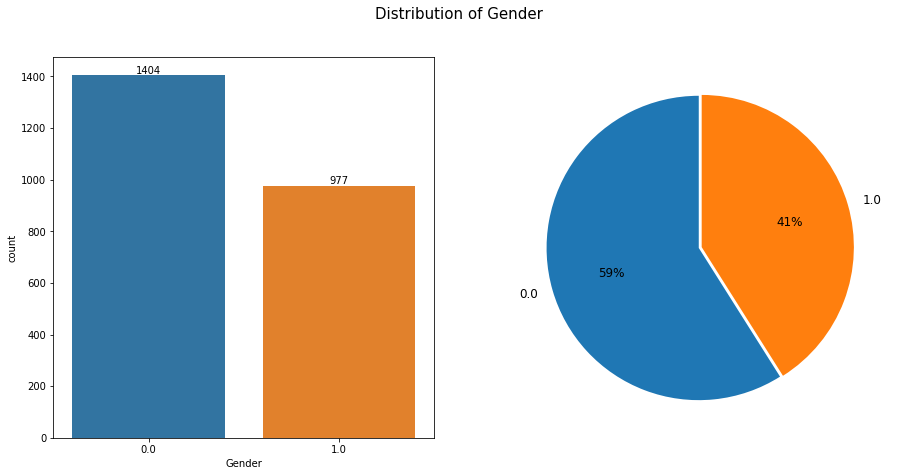

In [38]:
make_categorical_plots(agg_df, 'Gender')

__Findings:__
- 59% of the drivers are Male
- 41% of the drivers are Female

#### Education_Level

In [39]:
agg_df['Education_Level'].value_counts(normalize=True)*100

2    33.683326
1    33.389332
0    32.927341
Name: Education_Level, dtype: float64

In [40]:
agg_df['Education_Level'].nunique()

3

__Findings:__
- Education level – 0 for 10+ ,1 for 12+ ,2 for graduate

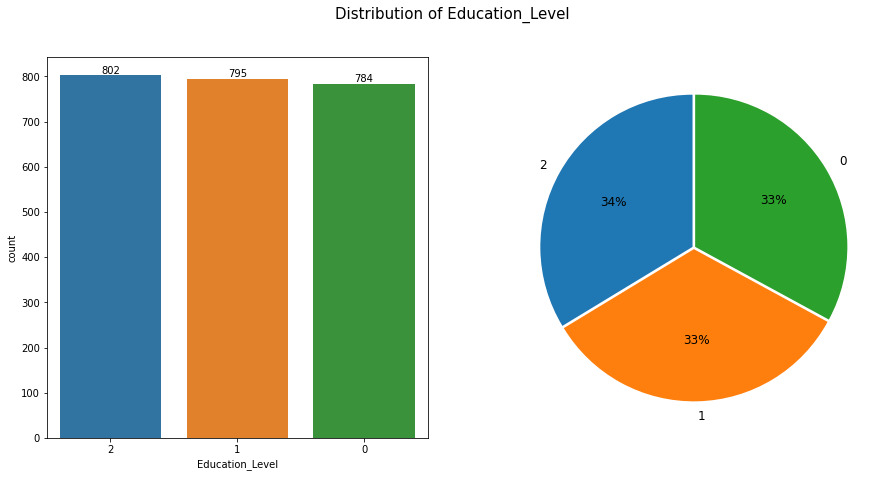

In [41]:
make_categorical_plots(agg_df, 'Education_Level')

__Findings:__
- We have similar number of Drivers for each of the Education Level

#### City

In [42]:
agg_df['City'].value_counts(normalize=True) * 100

C20    6.383872
C15    4.241915
C29    4.031919
C26    3.905922
C8     3.737925
C27    3.737925
C10    3.611928
C16    3.527929
C22    3.443931
C3     3.443931
C28    3.443931
C12    3.401932
C5     3.359933
C1     3.359933
C21    3.317934
C14    3.317934
C6     3.275934
C4     3.233935
C7     3.191936
C9     3.149937
C23    3.107938
C25    3.107938
C24    3.065939
C2     3.023940
C19    3.023940
C17    2.981940
C13    2.981940
C18    2.897942
C11    2.687946
Name: City, dtype: float64

In [43]:
agg_df['City'].nunique()

29

__Findings__
- The drivers are present in 29 different cities

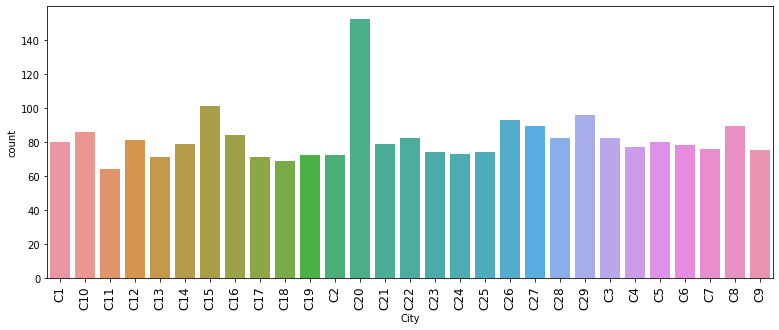

In [44]:
# assigning a graph to each ax
feature = 'City'
data = agg_df[feature].value_counts()
plt.figure(figsize=(13, 5))
ax = sns.countplot(data=agg_df, x=feature, order=sorted(data.index))
if len(data) > 8:
    ax.set_xticklabels(labels=sorted(data.index), rotation=90, fontsize=12)
plt.show()

__Findings__
- The count of Drivers from C20 is highest
- The count of Drivers from other cities are similar

#### Joining Designation

In [45]:
agg_df['Joining Designation'].value_counts(normalize=True)*100

1    43.091138
2    34.229315
3    20.705586
4     1.511970
5     0.461991
Name: Joining Designation, dtype: float64

In [46]:
agg_df['Joining Designation'].nunique()

5

__Findings:__
- Designation of the driver at the time of joining are categorized into 5 groups: 1, 2, 3, 4, and 5

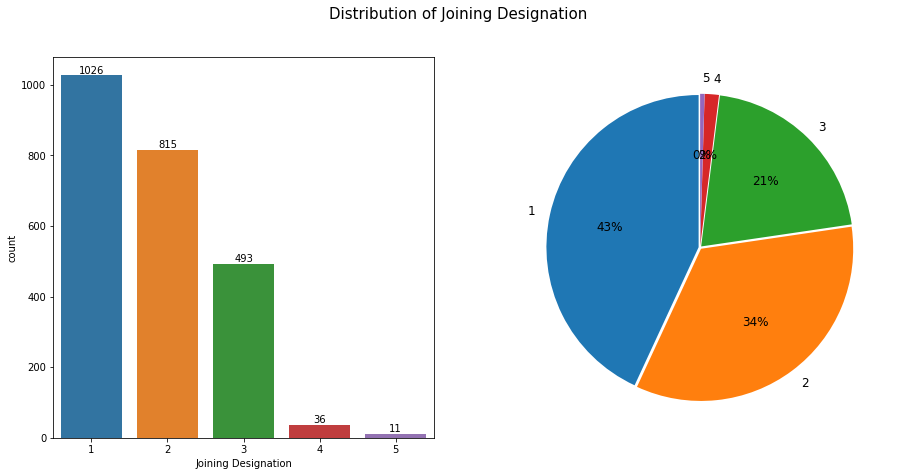

In [47]:
make_categorical_plots(agg_df, 'Joining Designation')

__Findings:__
- 43% of the drivers are given Joining Designation of "1", followed by "2", "3", "4", and "5"

#### Grade

In [48]:
agg_df['Grade'].value_counts(normalize=True)*100

2    35.909282
1    31.121378
3    26.165477
4     5.795884
5     1.007980
Name: Grade, dtype: float64

In [49]:
agg_df['Grade'].nunique()

5

__Findings:__
- The grade of the drivers at the time of reporting are designated using 5 different identifiers: 1, 2, 3, 4, and 5

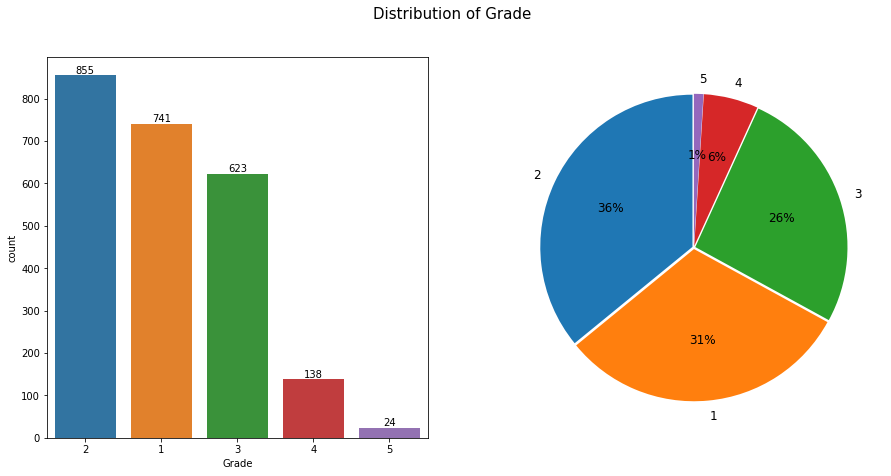

In [50]:
make_categorical_plots(agg_df, 'Grade')

__Findings:__
- Majority of the drivers at the time of reporting are given the grade 2, followed by 1, 3, 4, and 5

#### Quarterly Rating

In [51]:
agg_df['Quarterly Rating'].value_counts(normalize=True)*100

1    73.246535
2    15.203696
3     7.055859
4     4.493910
Name: Quarterly Rating, dtype: float64

In [52]:
agg_df['Quarterly Rating'].nunique()

4

__Findings:__
- 4 different identifiers are used to assign quarterly rating for the drivers: 1, 2, 3, and 4

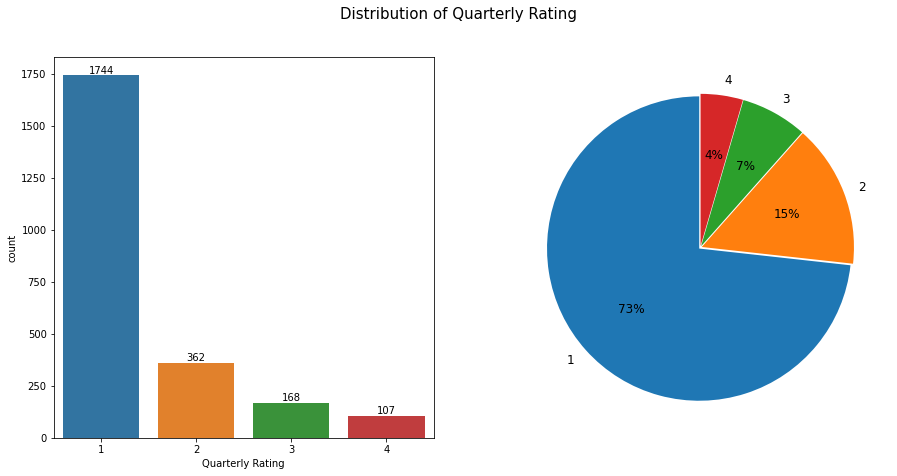

In [53]:
make_categorical_plots(agg_df, 'Quarterly Rating')

__Findings:__
- 73% of the drivers have quarterly rating of 1.
- Followed by 2, 3, and 4

### Numerical Attributes

In [54]:
def make_numerical_plots(df, feature, bins='auto'):
    """
    Method to make univariate numerical plot
    """
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    sns.boxplot(df[feature], ax=ax_box)
    sns.histplot(data=df, x=feature, ax=ax_hist, kde=True, bins=bins)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

def bi_cat_plot(df, x, target="loan_status"):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x, y=target)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)
    plt.show()

In [55]:
agg_df.select_dtypes('number').columns

Index(['Driver_ID', 'Age', 'Income', 'Total Business Value'], dtype='object')

#### Age

In [56]:
agg_df['Age'].describe()

count    2381.000000
mean       33.663167
std         5.983375
min        21.000000
25%        29.000000
50%        33.000000
75%        37.000000
max        58.000000
Name: Age, dtype: float64

__Findings:__
- The age of the Drivers range from 21 to 58
- The mean age of the Drivers is ~34. The median age is 33

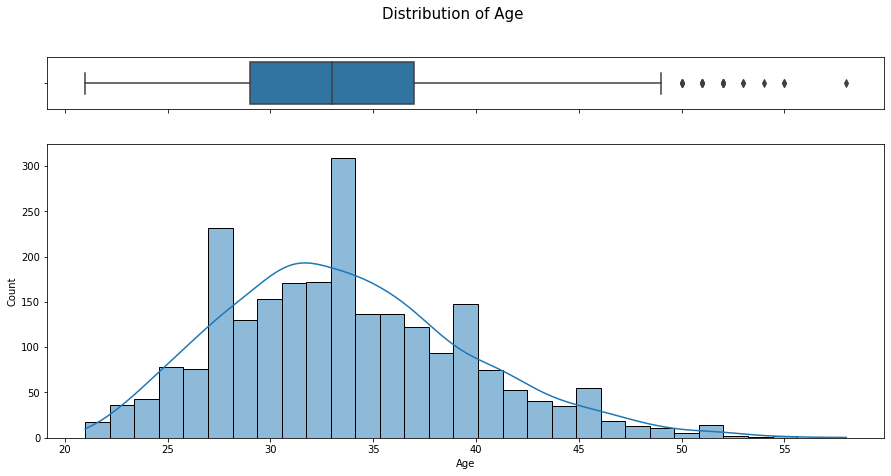

In [57]:
make_numerical_plots(agg_df, 'Age')

__Findings:__
- There are few outliers values

In [58]:
print(f'The values lying ouside of {quantile_boundaries(agg_df["Age"])} are considered outliers')
print(f'There are {outlier_count(agg_df["Age"])} outlier data points')

The values lying ouside of (17.0, 49.0) are considered outliers
There are 25 outlier data points


__Findings:__
- It is possible to have Drivers of age in the range 49-58 to be driving for the company. So we will not remove these data points

#### Income

In [59]:
agg_df['Income'].describe()

count      2381.000000
mean      59232.460484
std       28298.214012
min       10747.000000
25%       39104.000000
50%       55285.000000
75%       75835.000000
max      188418.000000
Name: Income, dtype: float64

__Findings:__
- The monthly income of the Drivers range between 10747 to 188418
- The mean income is 59232, and the median income is 55285

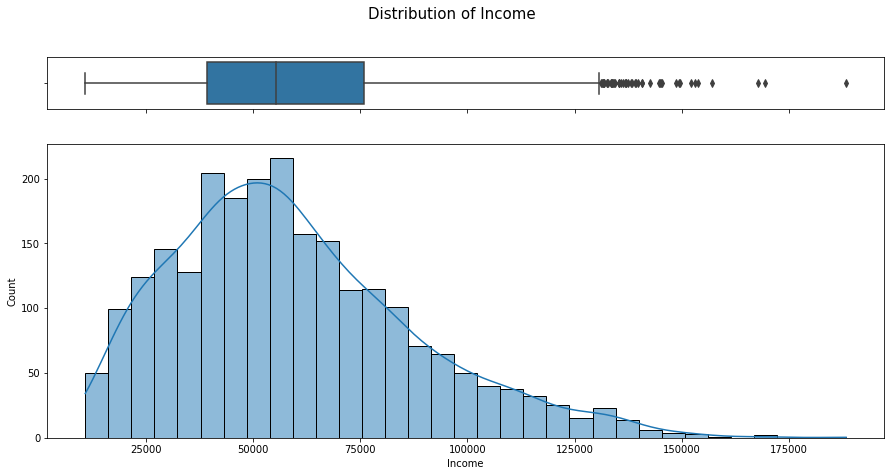

In [60]:
make_numerical_plots(agg_df, 'Income')

__Findings:__
- There are outliers values

In [61]:
print(f'The values lying ouside of {quantile_boundaries(agg_df["Income"])} are considered outliers')
print(f'There are {outlier_count(agg_df["Income"])} outlier data points')

The values lying ouside of (-15992.5, 130931.5) are considered outliers
There are 47 outlier data points


In [62]:
47 / agg_df.shape[0] * 100

1.9739605207895843

__Findings:__
- There are only ~2% of outliers in the data. We can safely remove these rows.

#### Total Business Value

In [63]:
agg_df['Total Business Value'].describe()

count    2.381000e+03
mean     3.120854e+05
std      4.495705e+05
min     -1.979329e+05
25%      0.000000e+00
50%      1.506244e+05
75%      4.294988e+05
max      3.972128e+06
Name: Total Business Value, dtype: float64

__Findings:__
- The total business value acquired by a Driver in a month range from -197933 to 3972128

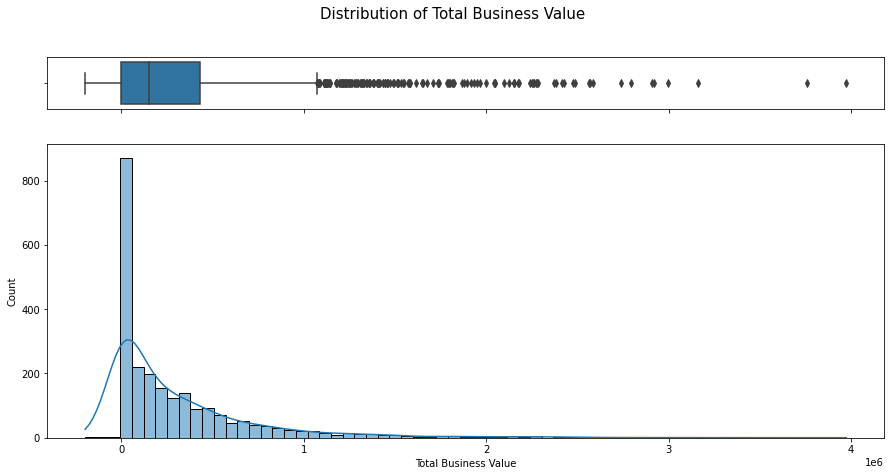

In [64]:
make_numerical_plots(agg_df, 'Total Business Value')

__Findings:__
- There are outliers values

In [65]:
print(f'The values lying ouside of {quantile_boundaries(agg_df["Total Business Value"])} are considered outliers')
print(f'There are {outlier_count(agg_df["Total Business Value"])} outlier data points')

The values lying ouside of (-644248.125, 1073746.875) are considered outliers
There are 148 outlier data points


In [66]:
148 / agg_df.shape[0] * 100

6.21587568248635

__Findings:__
- There are only ~6% of outliers in the data. We can safely remove these rows.

### Datetime Attributes

In [67]:
object_cols = ['MMM-YY', 'Dateofjoining', 'LastWorkingDate']
agg_df[object_cols].head()

,MMM-YY,Dateofjoining,LastWorkingDate
0,2019-03-01,2018-12-24,2019-03-11
1,2020-12-01,2020-11-06,NaT
2,2020-04-01,2019-12-07,2020-04-27
3,2019-03-01,2019-01-09,2019-03-07
4,2020-12-01,2020-07-31,NaT


#### MMM-YY

In [68]:
agg_df['MMM-YY'].describe()

count                    2381
unique                     24
top       2020-12-01 00:00:00
freq                      819
first     2019-01-01 00:00:00
last      2020-12-01 00:00:00
Name: MMM-YY, dtype: object

In [69]:
agg_df['MMM-YY'].nunique()

24

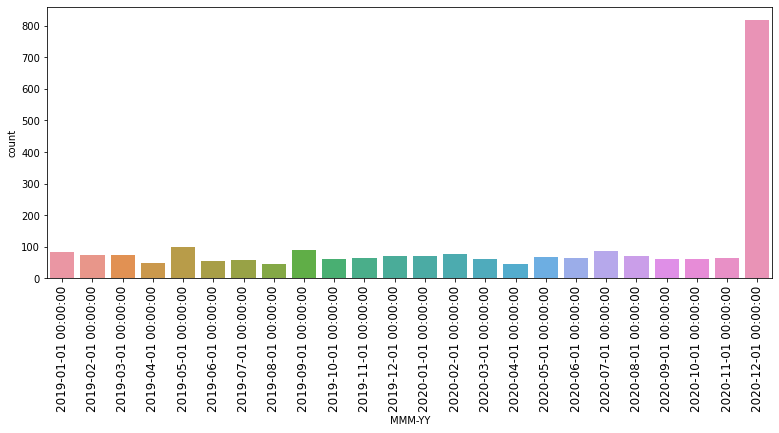

In [70]:
# assigning a graph to each ax
feature = 'MMM-YY'
data = agg_df[feature].value_counts()
plt.figure(figsize=(13, 5))
ax = sns.countplot(data=agg_df, x=feature, order=sorted(data.index))
if len(data) > 8:
    ax.set_xticklabels(labels=sorted(data.index), rotation=90, fontsize=12)
plt.show()

__Findings__
- We have data for 24 reporting months
- First reporting was made on January 2019, and the latest reporting was made on December 2020
- Most reports are made on December 2020


#### Dateofjoining

In [71]:
agg_df['Dateofjoining'].describe()

count                    2381
unique                    869
top       2020-07-31 00:00:00
freq                       31
first     2013-04-01 00:00:00
last      2020-12-28 00:00:00
Name: Dateofjoining, dtype: object

In [72]:
agg_df['Dateofjoining'].nunique()

869

__Findings__
- The drivers have joined the company as early as 2013 April
- The latest addition to the fleet was on 2020 December

In [73]:
feature = 'Dateofjoining'
data = agg_df[feature].dt.month
data.value_counts()

7     296
5     276
10    269
11    253
6     230
8     224
9     222
12    210
1     164
4     104
2      76
3      57
Name: Dateofjoining, dtype: int64

__Findings__
- July (7), May (5), and October (10) are the top 3 months with highest number of Drivers joining to the company fleet.

#### LastWorkingDate

In [74]:
agg_df['LastWorkingDate'].describe()


count                    1616
unique                    493
top       2020-07-29 00:00:00
freq                       70
first     2018-12-31 00:00:00
last      2020-12-28 00:00:00
Name: LastWorkingDate, dtype: object

In [75]:
agg_df['LastWorkingDate'].value_counts(dropna=False)

NaT           765
2020-07-29     70
2019-09-22     26
2019-03-17     14
2020-11-28     13
             ... 
2019-06-16      1
2020-11-17      1
2020-12-05      1
2019-09-02      1
2020-10-28      1
Name: LastWorkingDate, Length: 494, dtype: int64

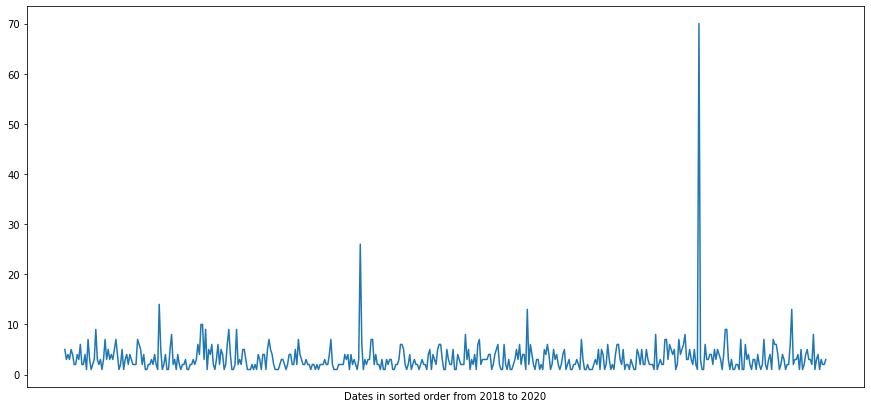

In [76]:
q = agg_df['LastWorkingDate'].value_counts().sort_index()

plt.figure(figsize=(15,7))
plt.plot(range(len(q)), q)
plt.xticks([], [])
plt.xlabel('Dates in sorted order from 2018 to 2020')
plt.show()


__Findings__

- We have LastWorkingData information from 2018 December to 2020 December.
- There are missing entries for many of the columns
- The rows having non-missing entries suggest, the Driver has churned. The rows having missing entries suggest the driver has not churned.
- There is no definite pattern of Drivers churn. However there are some peaks one some of the days
- This missing and non-missing entries can be used as the flag for the Driver Attrition problem we are working on, ie this flag will be our Target Attribute.

### Target Attribute

In [77]:
agg_df['target'] = agg_df['LastWorkingDate'].apply(lambda x: 1 - int(pd.isna(x)))

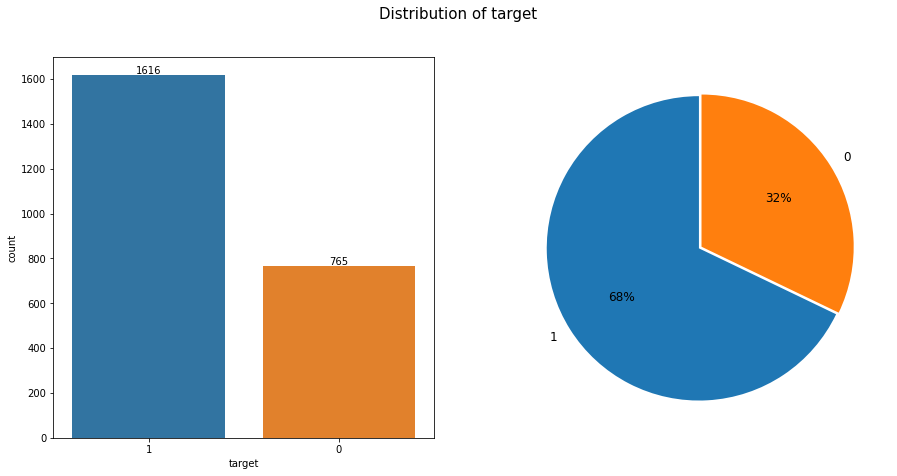

In [78]:
make_categorical_plots(agg_df, 'target')

__Findings:__
- We have a skewed distribution of data
- 68% of Drivers have churned. 32% of Drivers have not churned

## Cleaning the data

Before we move to bivariate analysis, we will remove the outliers, and any unwanted columns:

Following steps are done for cleaning:
- removing outliers using IQR method from numerical columns
- removing the datetime columns: "MMM-YY", "Dateofjoining", and "LastWorkingDate"

In [79]:
def clean_data(df, iqr_cols, unwanted_cols):

    # 1 --> get ranges
    fence_dict = {}
    for col in iqr_cols:
        fence_dict[col] = quantile_boundaries(df[col])
    print('Original Shape:', df.shape)

    # 2 --> remove using IQR
    for col in iqr_cols:
        low, high = fence_dict[col]
        df = df[(df[col]>=low) & (df[col]<=high)]

    # 3 --> remove unwanted cols
    df = df.drop(columns = unwanted_cols)
    print('Shape after cleaning', df.shape)

    return df

In [80]:
iqr_cols      = ['Income', 'Total Business Value']
unwanted_cols = ["MMM-YY", "Dateofjoining", "LastWorkingDate"]

cleaned_df = clean_data(agg_df, iqr_cols, unwanted_cols)

Original Shape: (2381, 14)
Shape after cleaning (2204, 11)


In [81]:
print(f'Percentage of rows removed = {np.round((len(agg_df) - len(cleaned_df)) / len(agg_df) * 100, 2)}%')

Percentage of rows removed = 7.43%


## Bivariate Analysis

The dependent variable for our problem statement is "target", and the remaing attribues are the independent variable. We will try to determine if a Driver will churn or not given a set of attributes about the Driver.

### Numericals

In [82]:
num_cols = cleaned_df.select_dtypes('number').columns
num_cols

Index(['Driver_ID', 'Age', 'Income', 'Total Business Value', 'target'], dtype='object')

In [83]:
def bi_cat_plot(df, x, target="target"):
    plt.figure(figsize=(12, 5))
    sns.violinplot(data=df, x=target, y=x)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)

#### Effect of Age on churn

In [84]:
target = 'target'
col    = 'Age'

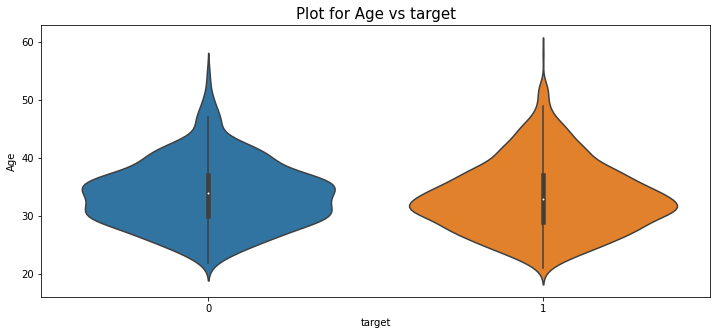

In [85]:
bi_cat_plot(cleaned_df, col)

In [86]:
cleaned_df.groupby(target)[col].mean()

target
0    33.760630
1    33.270236
Name: Age, dtype: float64

__Findings__:

- The mean age of Drivers who churn vs those who do not churn are similar.
- However, as the class labels are imbalanced, these mean values might not give the correct picture.

##### __Hypothesis testing to back the claim__

__Q Is the mean age of Drivers who churn vs Drivers who don't churn are similar?__

- The null hypothesis, Ho: There is no difference in the mean age
- The alternative hypothesis, Ha: There is difference in the mean age

Here, we will be conducting a 2-tailed test, with alpha = 0.05

One of the tests that we can use here is t-test. But there are certain assumptions that needs to be fulfilled before proceeding with the test. 

Some of the assumptions of t-test:
- the data, when plotted, results in a normal distribution, bell-shaped distribution curve.
- homogeneity of variance.

__Normality check__


We will perform normality check using Shapiro test.

The hypothesis of this test are:
- Null Hypothesis Ho - series is normal
- Alternative Hypothesis Ha - series is not normal

In [87]:
from scipy.stats import shapiro
def normality_check(series, alpha=0.05):
    _, p_value = shapiro(series)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

1. Distribution of target = 0

p value = 1.1320111070745043e-07
We reject the Null Hypothesis Ho


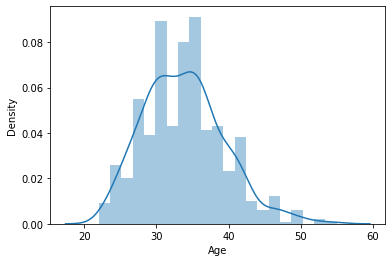

In [88]:
sns.distplot(cleaned_df[cleaned_df['target'] == 0]['Age'])
normality_check(cleaned_df[cleaned_df['target'] == 0]['Age'])

2. Distribution of target = 1

p value = 1.5973042387460584e-15
We reject the Null Hypothesis Ho


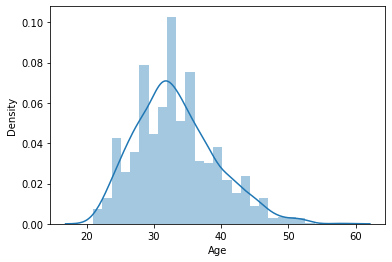

In [89]:
sns.distplot(cleaned_df[cleaned_df['target'] == 1]['Age'])
normality_check(cleaned_df[cleaned_df['target'] == 1]['Age'])


__Conclusions__
- All the distributions do not pass the normality check

__Equality of variance check__

We will perform equivalence check for using using Levene's test.

The hypothesis of this test are:
- Null Hypothesis Ho - Variances are equal
- Alternative Hypothesis Ha - Variances are not equal

In [90]:
from scipy.stats import levene
def variance_check(series1, series2, alpha=0.05):
    _, p_value = levene(series1, series2)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

In [91]:
variance_check(cleaned_df[cleaned_df['target'] == 0]['Age'], \
               cleaned_df[cleaned_df['target'] == 1]['Age'])

p value = 0.13954353907268915
We fail to reject the Null Hypothesis Ho


__Conclusion__

The distributions fail to satisfy the assumptions of t-test. 
Hence, we will use the non-parametric __Mann Whitney test__ to assess whether there is a statistically significant difference in the age for Drivers who churn vs those who do not churn.

__Mann Whitnet test__

The hypothesis of this test are:
- Null Hypothesis Ho - underlying distribution is same 
- Alternative Hypothesis Ha - underlying distribution is not same 

We will use alpha = 0.05

In [92]:
from scipy.stats import mannwhitneyu

def mann_whitney_test(series1, series2, alpha=0.05):
    _, p_value = mannwhitneyu(series1, series2)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

mann_whitney_test(cleaned_df[cleaned_df['target'] == 0]['Age'], \
                  cleaned_df[cleaned_df['target'] == 1]['Age'])

p value = 0.013819619829642388
We reject the Null Hypothesis Ho


__Inference__
- We *reject* the null hypothesis that "the age of Drivers who churn vs those who do not churn are similar"


#### Effect of Income on churn

In [93]:
col    = 'Income'

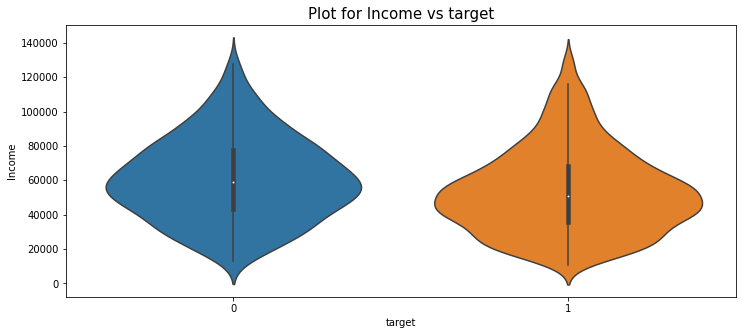

In [94]:
bi_cat_plot(cleaned_df, col)

In [95]:
cleaned_df.groupby(target)[col].mean()

target
0    60825.351137
1    53661.070108
Name: Income, dtype: float64

__Findings__:

- The mean Income of Drivers who churn is lower those who do not churn.
- However, as the class labels are imbalanced, these mean values might not give the correct picture.

##### __Hypothesis testing to back the claim__

__Q Is the mean Income of Drivers who churn is lower than those who do not churn?__

- The null hypothesis, Ho: The mean Income of Drivers who churn is lower than those who do not churn
- The alternative hypothesis, Ha: The mean Income of Drivers who churn is greater than those who do not churn

Here, we will be conducting a 1-tailed test, with alpha = 0.05

But there are certain assumptions that needs to be fulfilled before proceeding with the test. 

Some of the assumptions of t-test:
- the data, when plotted, results in a normal distribution, bell-shaped distribution curve.
- homogeneity of variance.

__Normality check__


We will perform normality check using Shapiro test.

The hypothesis of this test are:
- Null Hypothesis Ho - series is normal
- Alternative Hypothesis Ha - series is not normal

In [96]:
from scipy.stats import shapiro
def normality_check(series, alpha=0.05):
    _, p_value = shapiro(series)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

1. Distribution of target = 0

p value = 1.6788399079814553e-05
We reject the Null Hypothesis Ho


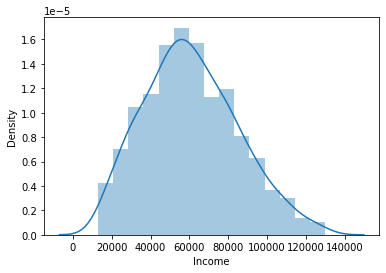

In [97]:
sns.distplot(cleaned_df[cleaned_df['target'] == 0]['Income'])
normality_check(cleaned_df[cleaned_df['target'] == 0]['Income'])

2. Distribution of target = 1

p value = 5.224649558740856e-19
We reject the Null Hypothesis Ho


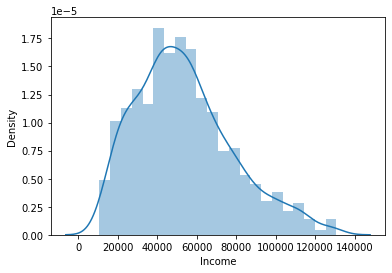

In [98]:
sns.distplot(cleaned_df[cleaned_df['target'] == 1]['Income'])
normality_check(cleaned_df[cleaned_df['target'] == 1]['Income'])


__Conclusions__
- All the distributions do not pass the normality check

__Equality of variance check__

We will perform equivalence check for using using Levene's test.

The hypothesis of this test are:
- Null Hypothesis Ho - Variances are equal
- Alternative Hypothesis Ha - Variances are not equal

In [99]:
from scipy.stats import levene
def variance_check(series1, series2, alpha=0.05):
    _, p_value = levene(series1, series2)
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

In [100]:
variance_check(cleaned_df[cleaned_df['target'] == 0]['Income'], \
               cleaned_df[cleaned_df['target'] == 1]['Income'])

p value = 0.9335426626443539
We fail to reject the Null Hypothesis Ho


__Conclusion__

The distributions fail to satisfy the assumptions of t-test. 
Hence, we will use the non-parametric __Mann Whitney test__ to assess whether there is a statistically significant difference in the age for Drivers who churn vs those who do not churn.

__Mann Whitnet test__

The hypothesis of this test are:
- Null Hypothesis Ho - underlying distribution of Income for Drivers who churn and those who do not churn are same
- Alternative Hypothesis Ha - the distribution underlying of Income for Drivers who churn is stochastically lesser than the distribution underlying Drivers who do not churn


We will use alpha = 0.05

In [101]:
from scipy.stats import mannwhitneyu

def mann_whitney_test(series1, series2, alpha=0.05):
    _, p_value = mannwhitneyu(series1, series2, alternative='less')
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

mann_whitney_test(cleaned_df[cleaned_df['target'] == 1]['Age'], \
                  cleaned_df[cleaned_df['target'] == 0]['Age'])

p value = 0.013819619829642372
We reject the Null Hypothesis Ho


__Inference__
- The underlying distribution of Income for Drivers who churn is stochatically lesser  those who do not churn are the same.


#### Effect of Total Business Value on churn

In [102]:
col    = 'Total Business Value'

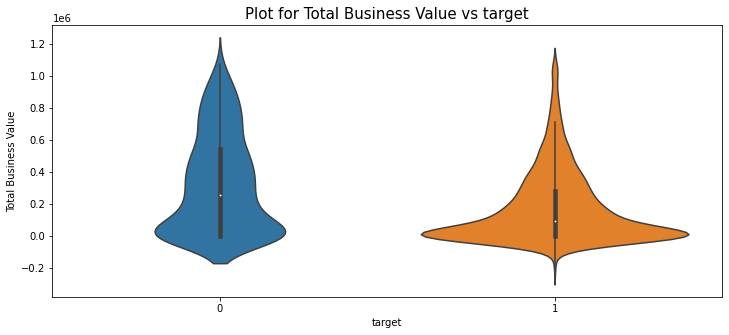

In [103]:
bi_cat_plot(cleaned_df, col)

In [104]:
cleaned_df.groupby(target)[col].mean()

target
0    325193.882367
1    178483.830668
Name: Total Business Value, dtype: float64

__Findings__:

- The mean total business value acquired by Drivers who churn is lower those who do not churn.
- However, as the class labels are imbalanced, these mean values might not give the correct picture.

##### __Hypothesis testing to back the claim__

__Q Is the mean Total Business Value of Drivers who churn is lower than those who do not churn?__

- The null hypothesis, Ho: The mean Total Business Value of Drivers who churn is lower than those who do not churn
- The alternative hypothesis, Ha: The mean Total Business Value of Drivers who churn is greater than those who do not churn

Here, we will be conducting a 1-tailed test, with alpha = 0.05

But there are certain assumptions that needs to be fulfilled before proceeding with the test. 

Some of the assumptions of t-test:
- the data, when plotted, results in a normal distribution, bell-shaped distribution curve.
- homogeneity of variance.

__Normality check__


We will perform normality check using Shapiro test.

The hypothesis of this test are:
- Null Hypothesis Ho - series is normal
- Alternative Hypothesis Ha - series is not normal

1. Distribution of target = 0

p value = 1.449729020022654e-20
We reject the Null Hypothesis Ho


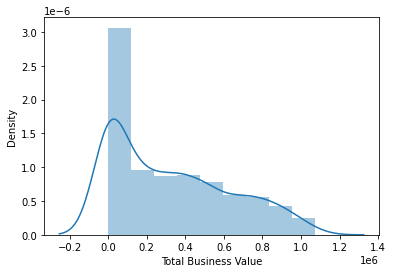

In [105]:
sns.distplot(cleaned_df[cleaned_df['target'] == 0]['Total Business Value'])
normality_check(cleaned_df[cleaned_df['target'] == 0]['Total Business Value'])

2. Distribution of target = 1

p value = 9.935724592494753e-40
We reject the Null Hypothesis Ho


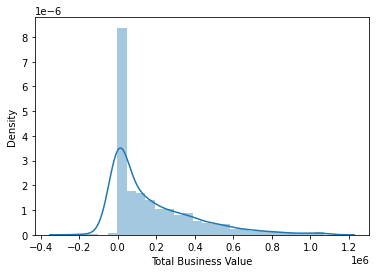

In [106]:
sns.distplot(cleaned_df[cleaned_df['target'] == 1]['Total Business Value'])
normality_check(cleaned_df[cleaned_df['target'] == 1]['Total Business Value'])


__Conclusions__
- All the distributions do not pass the normality check

__Equality of variance check__

We will perform equivalence check for using using Levene's test.

The hypothesis of this test are:
- Null Hypothesis Ho - Variances are equal
- Alternative Hypothesis Ha - Variances are not equal

In [107]:
variance_check(cleaned_df[cleaned_df['target'] == 0]['Total Business Value'], \
               cleaned_df[cleaned_df['target'] == 1]['Total Business Value'])

p value = 1.8193249347548204e-29
We reject the Null Hypothesis Ho


__Conclusion__

The distributions fail to satisfy the assumptions of t-test. 
Hence, we will use the non-parametric __Mann Whitney test__ to assess whether there is a statistically significant difference in the age for Drivers who churn vs those who do not churn.

__Mann Whitnet test__

The hypothesis of this test are:
- Null Hypothesis Ho - underlying distribution of Total Business Value for Drivers who churn and those who do not churn are same
- Alternative Hypothesis Ha - the distribution of Total Business Value underlying Drivers who churn is stochastically lesser than the distribution underlying Drivers who do not churn


We will use alpha = 0.05

In [108]:
from scipy.stats import mannwhitneyu

def mann_whitney_test(series1, series2, alpha=0.05):
    _, p_value = mannwhitneyu(series1, series2, alternative='less')
    print(f'p value = {p_value}')
    if p_value >= alpha:
        print('We fail to reject the Null Hypothesis Ho')
    else:
        print('We reject the Null Hypothesis Ho')

mann_whitney_test(cleaned_df[cleaned_df['target'] == 1]['Total Business Value'], \
                  cleaned_df[cleaned_df['target'] == 0]['Total Business Value'])

p value = 1.6023506656234456e-23
We reject the Null Hypothesis Ho


__Inference__
- The underlying distribution of Total Business Value for Drivers who churn is stochastically lesser than those who do not churn.


### Pairplot, Correlation

<Figure size 1080x504 with 0 Axes>

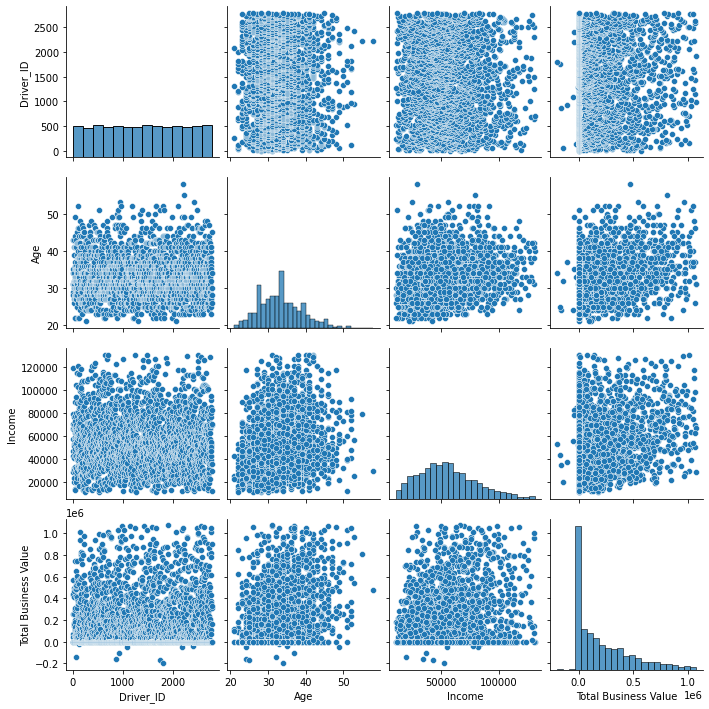

In [109]:
plt.figure(figsize=(15,7))
sns.pairplot(cleaned_df.drop(columns=['target']))
plt.show()

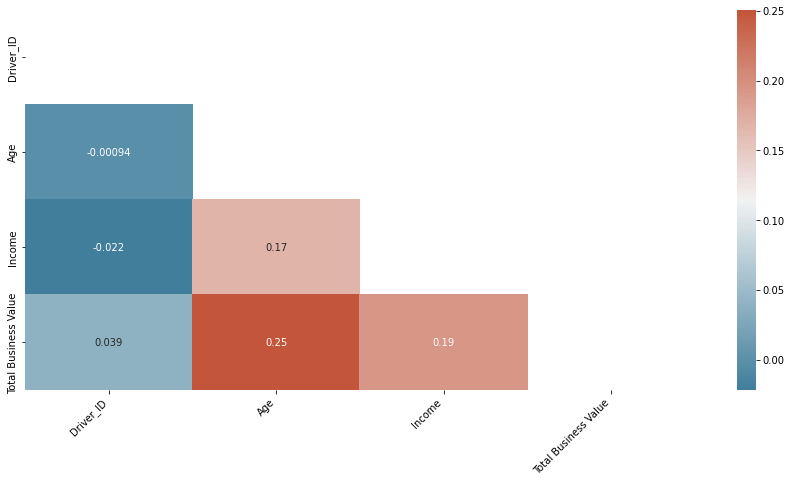

In [110]:
# Correlation between different variables
corr = cleaned_df.drop(columns=['target']).corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(15, 7))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

__Findings:__
- The independent variables do not show any strong correlation among themselves

### Feature Engineering

In the raw dataframe, we had multiple report for each Driver. 

In [111]:
df[df['Driver_ID']==1]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2


As the reports are made on different months, there is possibility that the Income and the Quarterly Rating of the Drivers changes over these time. We will try to capture this information using flags:
- 1 to denote if the value has increased
- 0 to denote if the value has decreased

In [112]:
income_flag_df = df.groupby(by='Driver_ID')['Income'].agg(['first','last']).reset_index()
income_flag_df.head()

,Driver_ID,first,last
0,1,57387,57387
1,2,67016,67016
2,4,65603,65603
3,5,46368,46368
4,6,78728,78728


In [113]:
rating_flag_df = df.groupby(by='Driver_ID')['Quarterly Rating'].agg(['first','last']).reset_index()
rating_flag_df.head()

,Driver_ID,first,last
0,1,2,2
1,2,1,1
2,4,1,1
3,5,1,1
4,6,1,2


In [114]:
income_flag_df['income_flag'] = income_flag_df[['first', 'last']].apply(lambda x: int(x[1] > x[0]), axis=1)
rating_flag_df['rating_flag'] = rating_flag_df[['first', 'last']].apply(lambda x: int(x[1] > x[0]), axis=1)

In [115]:
income_flag_df.head()

,Driver_ID,first,last,income_flag
0,1,57387,57387,0
1,2,67016,67016,0
2,4,65603,65603,0
3,5,46368,46368,0
4,6,78728,78728,0


In [116]:
rating_flag_df.head()

,Driver_ID,first,last,rating_flag
0,1,2,2,0
1,2,1,1,0
2,4,1,1,0
3,5,1,1,0
4,6,1,2,1


__Merging with the clean_df__:


In [117]:
final = pd.merge(cleaned_df, income_flag_df[['Driver_ID', 'income_flag']], how='inner', on='Driver_ID')
final.head(2)

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,income_flag
0,1,28.0,0.0,C23,2,57387.0,1,1,571860.0,2,1,0
1,2,31.0,0.0,C7,2,67016.0,2,2,0.0,1,0,0


In [118]:
final = pd.merge(final, rating_flag_df[['Driver_ID', 'rating_flag']], how='inner', on='Driver_ID')
final.head(2)

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,target,income_flag,rating_flag
0,1,28.0,0.0,C23,2,57387.0,1,1,571860.0,2,1,0,0
1,2,31.0,0.0,C7,2,67016.0,2,2,0.0,1,0,0,0


__Conclusion__
- Flags have been added for 'Income' and "Quarterly Rating"

### Categoricals

In [119]:
cols = ['Gender', 'Education_Level', 'City', 'Joining Designation', 'Grade', \
        'Quarterly Rating', 'rating_flag', 'income_flag']

#### Gender vs churn

In [120]:
pd.crosstab(cleaned_df['Gender'], cleaned_df['target'], normalize=True)

target,0,1
Gender,,
0.0,0.172414,0.418330
1.0,0.115699,0.293557


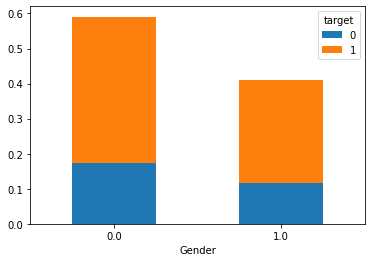

In [121]:
plot = pd.crosstab(cleaned_df['Gender'], cleaned_df['target'], normalize=True).plot(kind="bar", stacked=True, rot=0)

__Findings__
- Proportion of Male drivers churn is higher as compared to Female drivers

#### Education_Level vs churn

In [122]:
pd.crosstab(cleaned_df['Education_Level'], cleaned_df['target'], normalize=True)

target,0,1
Education_Level,,
0,0.091652,0.239564
1,0.099365,0.232305
2,0.097096,0.240018


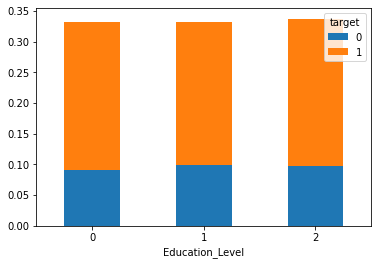

In [123]:
pd.crosstab(cleaned_df['Education_Level'], cleaned_df['target'], normalize=True).plot(kind="bar", stacked=True, rot=0)

__Findings__
- Proportion of Driver churn is similar for all the degrees

#### Joining Designation vs target

In [124]:
pd.crosstab(cleaned_df['Joining Designation'], cleaned_df['target'], normalize=True)

target,0,1
Joining Designation,,
1,0.098911,0.331216
2,0.095735,0.249546
3,0.091652,0.121143
4,0.001815,0.009074
5,0.000000,0.000907


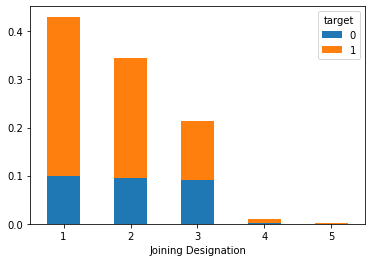

In [125]:
pd.crosstab(cleaned_df['Joining Designation'], cleaned_df['target'], normalize=True).plot(kind="bar", stacked=True, rot=0)

__Findings__
- Churn is highest among drivers whose Joining Designation is 1, followed by 2, 3, 4, and 5

#### Grade vs churn

In [126]:
pd.crosstab(cleaned_df['Grade'], cleaned_df['target'], normalize=True)

target,0,1
Grade,,
1,0.064882,0.269510
2,0.107078,0.269964
3,0.109347,0.148367
4,0.006806,0.022232
5,0.000000,0.001815


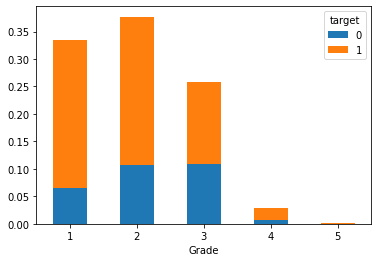

In [127]:
pd.crosstab(cleaned_df['Grade'], cleaned_df['target'], normalize=True).plot(kind="bar", stacked=True, rot=0)

__Findings__
- Churn is highest among Drivers with grade 1 and 2.

#### Quarterly Rating vs churn

In [128]:
pd.crosstab(cleaned_df['Quarterly Rating'], cleaned_df['target'], normalize=True)


target,0,1
Quarterly Rating,,
1,0.132486,0.636116
2,0.078494,0.063067
3,0.053085,0.009982
4,0.024047,0.002722


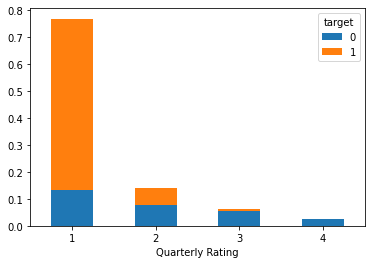

In [129]:
pd.crosstab(cleaned_df['Quarterly Rating'], cleaned_df['target'], normalize=True).plot(kind="bar", stacked=True, rot=0)

__Findings__
- Churn is highest among Drivers with Quarterly Rating of 1

#### income_flag vs churn

In [130]:
pd.crosstab(final['income_flag'], cleaned_df['target'], normalize=True)

target,0,1
income_flag,,
0,0.288802,0.705305
1,0.001965,0.003929


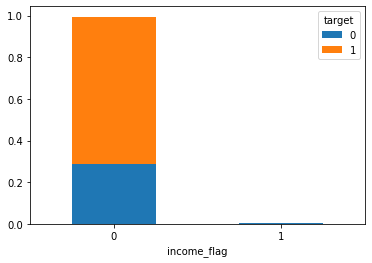

In [131]:
pd.crosstab(final['income_flag'], cleaned_df['target'], normalize=True).plot(kind="bar", stacked=True, rot=0)

__Findings__
- Churn is highest among Drivers whose monthly income did not increase over time

#### rating_flag vs churn

In [132]:
pd.crosstab(final['rating_flag'], cleaned_df['target'], normalize=True)

target,0,1
rating_flag,,
0,0.251473,0.609528
1,0.039293,0.099705


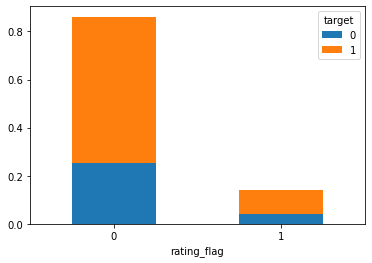

In [133]:
pd.crosstab(final['rating_flag'], cleaned_df['target'], normalize=True).plot(kind="bar", stacked=True, rot=0)

__Findings__
- Churn is highest among Drivers whose rating did not increase over time

#### City vs churn

In [134]:
pd.crosstab(final['City'], final['target'], normalize=True)

target,0,1
City,,
C1,0.009528,0.024501
C10,0.009074,0.026770
C11,0.006806,0.019510
C12,0.009528,0.024047
C13,0.003630,0.024955
C14,0.006806,0.024501
C15,0.012250,0.031307
C16,0.012250,0.022232
C17,0.006806,0.024501


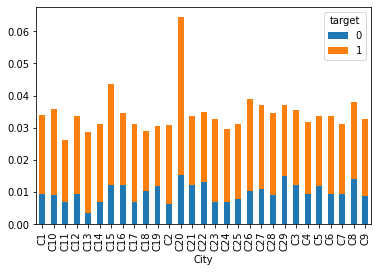

In [135]:
pd.crosstab(final['City'], final['target'], normalize=True).plot(kind="bar", stacked=True, rot=90)

__Findings__
- Churn is highest among Drivers from the city code C20
- For rest of the cities, the churn rate is similar

# Data Preparation + Modelling

Before we proceed further, we will split the data into train, and test set. 

As we are dealing with an imbalanced data, we will do __stratified splitting__ instead of __random splitting__.

In [136]:
from sklearn.model_selection import train_test_split

Y = final['target']
X = final.drop(columns=['target', 'Driver_ID'])

In [137]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

print('-'*15, 'Shapes', '-'*15)
print(f'Train      data shape: {x_train.shape}')
print(f'Test       data shape: {x_test.shape}')

--------------- Shapes ---------------
Train      data shape: (1763, 11)
Test       data shape: (441, 11)


### Impute Missing Values

Checking for missing values, if any, before proceeding with data processing:

In [138]:
print(x_train.isna().sum())

Age                     0
Gender                  0
City                    0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
income_flag             0
rating_flag             0
dtype: int64


## Modelling - Iteration 1

- Without any data balancing
- OHE on categoricals

We will encode the categorical features and scale the numerical features before modelling.

In [139]:
num_cols     = ['Age', 'Income', 'Total Business Value']
cat_cols_nom = ['Gender', 'City', 'income_flag', 'rating_flag']
cat_cols_ord = ['Education_Level', 'Joining Designation', 'Grade', 'Quarterly Rating']


#### Encode categoricals


__NOMINAL__

In [140]:
x_train_ohe = pd.get_dummies(x_train[cat_cols_nom], drop_first=True)
x_train_ohe.head(3)

,income_flag,rating_flag,Gender_1.0,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,City_C19,City_C2,City_C20,City_C21,City_C22,City_C23,City_C24,City_C25,City_C26,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
1194,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1892,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [141]:
x_test_ohe = pd.get_dummies(x_test[cat_cols_nom], drop_first=True)

__ORDINAL__

- These columns are already processed

#### Scale numericals

- These columns will be scaled in the Pipeline to prevent data leakage

In [143]:
for col in num_cols:
    x_train_ohe[col] = x_train[col]
    x_test_ohe[col]  = x_test[col]

### Bagging Model

We now have our data ready for modelling. 


As the data is only slightly imbalanced, we are using ROC_AUC score to measure the model performances.

<h4> Hyper paramter tuning to find best hyperparams:</h4>

In [145]:
ct = ColumnTransformer([('scaling', StandardScaler(), num_cols)], remainder='passthrough')
rfc = RandomForestClassifier(n_jobs = -1, random_state = 10)

param_grid = {
    'randomforest__n_estimators' : [10, 50, 100, 150, 200], 
    'randomforest__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforest__max_samples': [0.6, 0.7, 0.8, 0.9, 1]
}

pipe_rfc = Pipeline([
    ('columntransform', ct),
    ('randomforest', rfc)
    ])

clf = RandomizedSearchCV(pipe_rfc, param_grid, cv=5, scoring='roc_auc', verbose=1)
clf.fit(x_train_ohe,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Total '
                                                                                'Business '
                                                                                'Value'])])),
                                             ('randomforest',
                                              RandomForestClassifier(n_jobs=-1,
                                        

In [146]:
print("best parameters: ",clf.best_params_)
print("best score: ", clf.best_score_)

best parameters:  {'randomforest__n_estimators': 200, 'randomforest__max_samples': 0.8, 'randomforest__max_depth': 5}
best score:  0.7351931044991071


<h4> Training the model with the best classifier</h4>

In [147]:
randf = clf.best_estimator_
randf.fit(x_train_ohe, y_train)

Pipeline(steps=[('columntransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['Age', 'Income',
                                                   'Total Business Value'])])),
                ('randomforest',
                 RandomForestClassifier(max_depth=5, max_samples=0.8,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=10))])

In [148]:
y_train_pred = randf.predict(x_train_ohe)
y_test_pred = randf.predict(x_test_ohe)

y_train_pred_proba = randf.predict_proba(x_train_ohe)[:, 1]
y_test_pred_proba = randf.predict_proba(x_test_ohe)[:, 1]

__AUC ROC__

In [149]:
model1_auc_train = roc_auc_score(y_train, y_train_pred_proba)
model1_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model1_auc_train}, Test AUC: {model1_auc_test}')

Train AUC: 0.8075399190639018, Test AUC: 0.6938412157079091


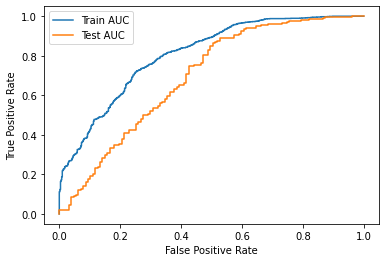

In [150]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent test AUC score
- There is a little gap between train and test. This means the model is slightly overfitting.

__Classification Report__

In [151]:
print(classification_report(y_test, y_test_pred, target_names=['Do not churn', 'Churn']))

              precision    recall  f1-score   support

Do not churn       0.74      0.35      0.48       127
       Churn       0.78      0.95      0.86       314

    accuracy                           0.78       441
   macro avg       0.76      0.65      0.67       441
weighted avg       0.77      0.78      0.75       441



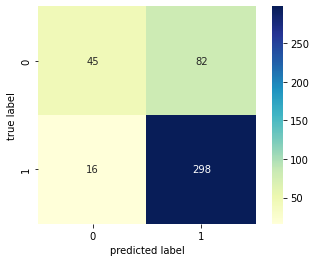

In [152]:
mat = confusion_matrix(y_test, y_test_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

- The RECALL for churn class is good (0.95)
- The PRECISION for Churn class is descent (0.78)

### Boosting Model

In [155]:
import xgboost as xgb

<h4> Hyper paramter tuning to find best hyperparams:</h4>

In [156]:
ct = ColumnTransformer([('scaling', StandardScaler(), num_cols)], remainder='passthrough')
xgc = xgb.XGBClassifier(n_jobs = -1, random_state = 10)

param_grid = {
    'xgb__n_estimators' : [50, 100, 150, 200, 300], 
    'xgb__max_depth' : [2, 3, 4, 5],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'xgb__learning_rate': [0.4, 0.6, 0.8]
}

pipe_rfc = Pipeline([
    ('columntransform', ct),
    ('xgb', xgc)
    ])

clf2 = RandomizedSearchCV(pipe_rfc, param_grid, cv=5, scoring='roc_auc', verbose=1)
clf2.fit(x_train_ohe,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Total '
                                                                                'Business '
                                                                                'Value'])])),
                                             ('xgb',
                                              XGBClassifier(n_jobs=-1,
                                                          

In [157]:
print("best parameters: ",clf2.best_params_)
print("best score: ", clf2.best_score_)

best parameters:  {'xgb__subsample': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.4}
best score:  0.7124730741178171


<h4> Training the model with the best classifier</h4>

In [158]:
xgcf = clf2.best_estimator_
xgcf.fit(x_train_ohe, y_train)

Pipeline(steps=[('columntransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['Age', 'Income',
                                                   'Total Business Value'])])),
                ('xgb',
                 XGBClassifier(learning_rate=0.4, n_estimators=50, n_jobs=-1,
                               random_state=10))])

In [159]:
y_train_pred = xgcf.predict(x_train_ohe)
y_test_pred = xgcf.predict(x_test_ohe)

y_train_pred_proba = xgcf.predict_proba(x_train_ohe)[:, 1]
y_test_pred_proba = xgcf.predict_proba(x_test_ohe)[:, 1]

__AUC ROC__

In [160]:
model2_auc_train = roc_auc_score(y_train, y_train_pred_proba)
model2_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model2_auc_train}, Test AUC: {model2_auc_test}')

Train AUC: 0.8913911283997866, Test AUC: 0.6855032850193089


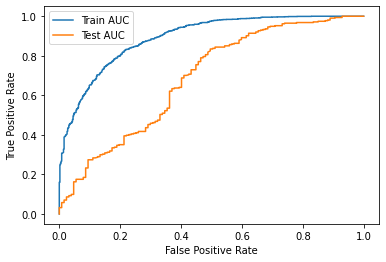

In [161]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent test AUC score
- But there is a high gap between train and test. This means the model is  overfitting a lot.

__Classification Report__

In [163]:
print(classification_report(y_test, y_test_pred, target_names=['Do not churn', 'Churn']))

              precision    recall  f1-score   support

Do not churn       0.59      0.39      0.47       127
       Churn       0.78      0.89      0.83       314

    accuracy                           0.75       441
   macro avg       0.69      0.64      0.65       441
weighted avg       0.73      0.75      0.73       441



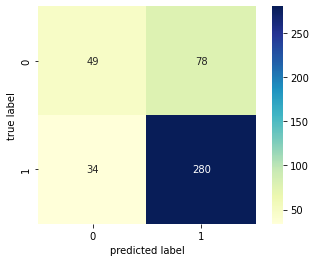

In [164]:
mat = confusion_matrix(y_test, y_test_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

- The RECALL for Churn class is good (0.89)
- The PRECISION for churn class is also good (0.78).

## Modelling - Iteration 2

- Without any data balancing
- Categorical Encoding on categoricals

In [167]:
num_cols     = ['Age', 'Income', 'Total Business Value']
cat_cols_nom = ['Gender', 'City', 'income_flag', 'rating_flag']
cat_cols_ord = ['Education_Level', 'Joining Designation', 'Grade', 'Quarterly Rating']

#### Encode categoricals


__NOMINAL__

- We will use Target Encoder to encode the nominal categories. This step will be applied in the Pipeline to prevent data leakage

__ORDINAL__

- These columns are already processed

#### Scale numericals

- These columns will be scaled in the Pipeline to prevent data leakage

### Bagging Model

<h4> Hyper paramter tuning to find best hyperparams:</h4>

In [168]:
ct = ColumnTransformer([('scaling', StandardScaler(), num_cols),
                        ('encoding', ce.TargetEncoder(), cat_cols_nom)
                        ], remainder='passthrough')
rfc = RandomForestClassifier(n_jobs = -1, random_state = 10)

param_grid = {
    'randomforest__n_estimators' : [10, 50, 100, 150, 200], 
    'randomforest__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforest__max_samples': [0.6, 0.7, 0.8, 0.9, 1]
}

pipe_rfc = Pipeline([
    ('columntransform', ct),
    ('randomforest', rfc)
    ])

clf = RandomizedSearchCV(pipe_rfc, param_grid, cv=5, scoring='roc_auc', verbose=1)
clf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Total '
                                                                                'Business '
                                                                                'Value']),
                                                                              ('encoding',
                                                                               TargetEncoder()

In [169]:
print("best parameters: ",clf.best_params_)
print("best score: ", clf.best_score_)

best parameters:  {'randomforest__n_estimators': 200, 'randomforest__max_samples': 0.9, 'randomforest__max_depth': 6}
best score:  0.8014292664326194


<h4> Training the model with the best classifier</h4>

In [170]:
randf = clf.best_estimator_
randf.fit(x_train, y_train)

Pipeline(steps=[('columntransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['Age', 'Income',
                                                   'Total Business Value']),
                                                 ('encoding', TargetEncoder(),
                                                  ['Gender', 'City',
                                                   'income_flag',
                                                   'rating_flag'])])),
                ('randomforest',
                 RandomForestClassifier(max_depth=6, max_samples=0.9,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=10))])

In [171]:
y_train_pred = randf.predict(x_train)
y_test_pred = randf.predict(x_test)

y_train_pred_proba = randf.predict_proba(x_train)[:, 1]
y_test_pred_proba = randf.predict_proba(x_test)[:, 1]

__AUC ROC__

In [172]:
model3_auc_train = roc_auc_score(y_train, y_train_pred_proba)
model3_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model3_auc_train}, Test AUC: {model3_auc_test}')

Train AUC: 0.8790679800483108, Test AUC: 0.7840664025277095


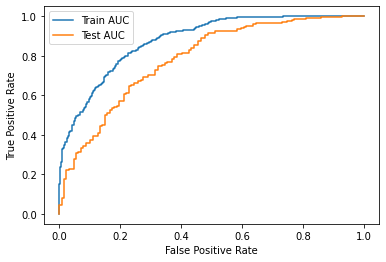

In [173]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent test AUC score
- There is a little gap between train and test. This means the model is  a good fit.

__Classification Report__

In [174]:
print(classification_report(y_test, y_test_pred, target_names=['Do not churn', 'Churn']))

              precision    recall  f1-score   support

Do not churn       0.71      0.47      0.57       127
       Churn       0.81      0.92      0.86       314

    accuracy                           0.79       441
   macro avg       0.76      0.70      0.72       441
weighted avg       0.78      0.79      0.78       441



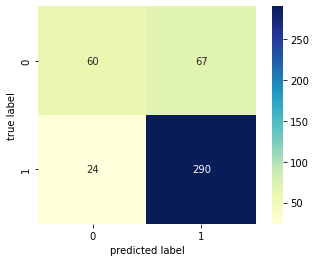

In [175]:
mat = confusion_matrix(y_test, y_test_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

- The RECALL for Churn class is good (0.92)
- The PRECISION for Churn class is also good (0.81).

### Boosting Model

In [178]:
import xgboost as xgb

<h4> Hyper paramter tuning to find best hyperparams:</h4>

In [179]:
ct = ColumnTransformer([('scaling', StandardScaler(), num_cols),
                        ('encoding', ce.TargetEncoder(), cat_cols_nom)
                        ], remainder='passthrough')
xgc = xgb.XGBClassifier(n_jobs = -1, random_state = 10)

param_grid = {
    'xgb__n_estimators' : [50, 100, 150, 200, 300], 
    'xgb__max_depth' : [2, 3, 4, 5, 6, 7, 8],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'xgb__learning_rate': [0.4, 0.6, 0.8]
}

pipe_rfc = Pipeline([
    ('columntransform', ct),
    ('xgb', xgc)
    ])

clf = RandomizedSearchCV(pipe_rfc, param_grid, cv=5, scoring='roc_auc', verbose=1)
clf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Total '
                                                                                'Business '
                                                                                'Value']),
                                                                              ('encoding',
                                                                               TargetEncoder()

In [180]:
print("best parameters: ",clf.best_params_)
print("best score: ", clf.best_score_)

best parameters:  {'xgb__subsample': 1, 'xgb__n_estimators': 50, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.4}
best score:  0.7661777661243978


<h4> Training the model with the best classifier</h4>

In [181]:
xgcf = clf.best_estimator_
xgcf.fit(x_train, y_train)

Pipeline(steps=[('columntransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['Age', 'Income',
                                                   'Total Business Value']),
                                                 ('encoding', TargetEncoder(),
                                                  ['Gender', 'City',
                                                   'income_flag',
                                                   'rating_flag'])])),
                ('xgb',
                 XGBClassifier(learning_rate=0.4, max_depth=4, n_estimators=50,
                               n_jobs=-1, random_state=10))])

In [182]:
y_train_pred = xgcf.predict(x_train)
y_test_pred = xgcf.predict(x_test)

y_train_pred_proba = xgcf.predict_proba(x_train)[:, 1]
y_test_pred_proba = xgcf.predict_proba(x_test)[:, 1]

__AUC ROC__

In [183]:
model4_auc_train = roc_auc_score(y_train, y_train_pred_proba)
model4_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model4_auc_train}, Test AUC: {model4_auc_test}')

Train AUC: 0.9632791667973774, Test AUC: 0.7635036862430411


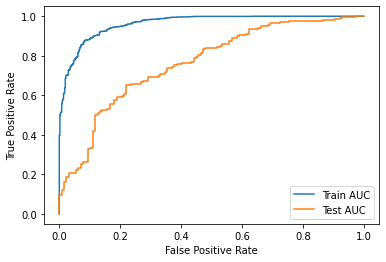

In [184]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent test AUC score
- But there is a high gap between train and test. This means the model is  overfitting a lot.

__Classification Report__

In [185]:
print(classification_report(y_test, y_test_pred, target_names=['Do not churn', 'Churn']))

              precision    recall  f1-score   support

Do not churn       0.58      0.44      0.50       127
       Churn       0.79      0.87      0.83       314

    accuracy                           0.75       441
   macro avg       0.69      0.66      0.66       441
weighted avg       0.73      0.75      0.73       441



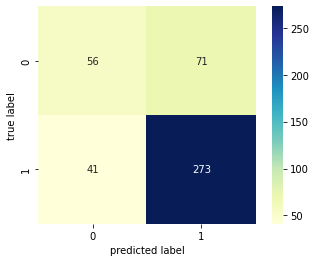

In [186]:
mat = confusion_matrix(y_test, y_test_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

- The RECALL for Churn class is good (0.87)
- The PRECISION for Churn class is also good (0.79).

## Summary

In [189]:
train_auc = [model1_auc_train, model2_auc_train, model3_auc_train, model4_auc_train]
test_auc  = [model1_auc_test, model2_auc_test, model3_auc_test, model4_auc_test]
encoding = ['OHE', 'OHE', 'Target Encoding', 'Target Encoding']
balance = ['None', 'None', 'None', 'None']

x = PrettyTable(["Model", "Train AUC", "Test AUC", "Encoding", 'Balancing'])
i = 1
for a, b,c, d in zip(train_auc, test_auc, encoding, balance):
    x.add_row(['Model '+str(i), a, b, c, d])
    x.add_row([' ', ' ', ' ', ' ', ' '])
    i += 1
print(x)

+---------+--------------------+--------------------+-----------------+-----------+
|  Model  |     Train AUC      |      Test AUC      |     Encoding    | Balancing |
+---------+--------------------+--------------------+-----------------+-----------+
| Model 1 | 0.8075399190639018 | 0.6938412157079091 |       OHE       |    None   |
|         |                    |                    |                 |           |
| Model 2 | 0.8913911283997866 | 0.6855032850193089 |       OHE       |    None   |
|         |                    |                    |                 |           |
| Model 3 | 0.8790679800483108 | 0.7840664025277095 | Target Encoding |    None   |
|         |                    |                    |                 |           |
| Model 4 | 0.9632791667973774 | 0.7635036862430411 | Target Encoding |    None   |
|         |                    |                    |                 |           |
+---------+--------------------+--------------------+-----------------+-----

- The best scores we have is for Model 2. This model was trained after class balancing.

## Modelling - Iteration 3

- With class balancing (using SMOTE)
- Categorical Encoding on categoricals

In [190]:
num_cols     = ['Age', 'Income', 'Total Business Value']
cat_cols_nom = ['Gender', 'City', 'income_flag', 'rating_flag']
cat_cols_ord = ['Education_Level', 'Joining Designation', 'Grade', 'Quarterly Rating']

#### Upsampling Using SMOTE

The City column contains values as STRING. So we will convert them to numeric values before we proceed with SMOTE:

In [191]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(x_train['City'])
x_train['City'] = le.transform(x_train['City'])
x_test['City']  = le.transform(x_test['City'])

In [192]:
oversample = SMOTE(random_state=42)
x_train_smote, y_train_smote = oversample.fit_resample(x_train, y_train)

In [193]:
print('Ratio of labels before balancing:')
print(y_train.value_counts())
print('\n'*2)
print('Ratio of labels after balancing:')
print(y_train_smote.value_counts())

Ratio of labels before balancing:
1    1255
0     508
Name: target, dtype: int64



Ratio of labels after balancing:
0    1255
1    1255
Name: target, dtype: int64


In [194]:
x_train_smote.isnull().sum()

Age                       0
Gender                  359
City                      0
Education_Level         482
Income                    0
Joining Designation     403
Grade                   410
Total Business Value      0
Quarterly Rating        283
income_flag               0
rating_flag               0
dtype: int64

Some missing values were introduced after oversampling with SMOTE.
(__NOT SURE WHY!__). We will use KNN imputation to fill the missing values.

In [195]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

x_train_imputed = imputer.fit_transform(x_train_smote)
x_train_f = pd.DataFrame(x_train_imputed, columns = x_train.columns)

In [196]:
x_train_f.isnull().sum()

Age                     0
Gender                  0
City                    0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
income_flag             0
rating_flag             0
dtype: int64

__Findings__
- Missing values filled successfully

#### Encode categoricals


__NOMINAL__

- We will use Target Encoder to encode the nominal categories. This step will be applied in the Pipeline to prevent data leakage

__ORDINAL__

- These columns are already processed

#### Scale numericals

- These columns will be scaled in the Pipeline to prevent data leakage

### Bagging Model

<h4> Hyper paramter tuning to find best hyperparams:</h4>

In [197]:
ct = ColumnTransformer([('scaling', StandardScaler(), num_cols),
                        ('encoding', ce.TargetEncoder(), cat_cols_nom)
                        ], remainder='passthrough')
rfc = RandomForestClassifier(n_jobs = -1, random_state = 10)

param_grid = {
    'randomforest__n_estimators' : [10, 50, 100, 150, 200], 
    'randomforest__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforest__max_samples': [0.6, 0.7, 0.8, 0.9, 1]
}

pipe_rfc = Pipeline([
    ('columntransform', ct),
    ('randomforest', rfc)
    ])

clf = RandomizedSearchCV(pipe_rfc, param_grid, cv=5, scoring='roc_auc', verbose=1)
clf.fit(x_train_f, y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Total '
                                                                                'Business '
                                                                                'Value']),
                                                                              ('encoding',
                                                                               TargetEncoder()

In [198]:
print("best parameters: ",clf.best_params_)
print("best score: ", clf.best_score_)

best parameters:  {'randomforest__n_estimators': 10, 'randomforest__max_samples': 0.9, 'randomforest__max_depth': 10}
best score:  0.8904985635148648


<h4> Training the model with the best classifier</h4>

In [199]:
randf = clf.best_estimator_
randf.fit(x_train, y_train)

Pipeline(steps=[('columntransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['Age', 'Income',
                                                   'Total Business Value']),
                                                 ('encoding', TargetEncoder(),
                                                  ['Gender', 'City',
                                                   'income_flag',
                                                   'rating_flag'])])),
                ('randomforest',
                 RandomForestClassifier(max_depth=10, max_samples=0.9,
                                        n_estimators=10, n_jobs=-1,
                                        random_state=10))])

In [200]:
y_train_pred = randf.predict(x_train)
y_test_pred = randf.predict(x_test)

y_train_pred_proba = randf.predict_proba(x_train)[:, 1]
y_test_pred_proba = randf.predict_proba(x_test)[:, 1]

__AUC ROC__

In [201]:
model5_auc_train = roc_auc_score(y_train, y_train_pred_proba)
model5_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model5_auc_train}, Test AUC: {model5_auc_test}')

Train AUC: 0.9588692474197698, Test AUC: 0.7409599277797281


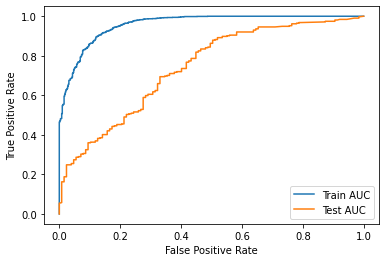

In [202]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent test AUC score
- But there is a high gap between train and test. This means the model is  overfitting a lot.

__Classification Report__

In [203]:
print(classification_report(y_test, y_test_pred, target_names=['Do not churn', 'Churn']))

              precision    recall  f1-score   support

Do not churn       0.64      0.48      0.55       127
       Churn       0.81      0.89      0.85       314

    accuracy                           0.77       441
   macro avg       0.73      0.69      0.70       441
weighted avg       0.76      0.77      0.76       441



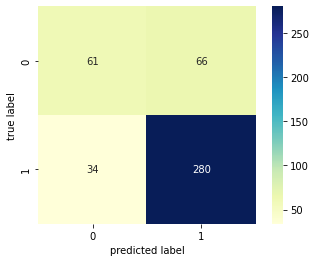

In [204]:
mat = confusion_matrix(y_test, y_test_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

- The RECALL for Churn class is good (0.89). 
- The PRECISION for Churn class is good as well (0.81).

### Boosting Model

In [207]:
import xgboost as xgb

<h4> Hyper paramter tuning to find best hyperparams:</h4>

In [208]:
ct = ColumnTransformer([('scaling', StandardScaler(), num_cols),
                        ('encoding', ce.TargetEncoder(), cat_cols_nom)
                        ], remainder='passthrough')
xgc = xgb.XGBClassifier(n_jobs = -1, random_state = 10)

param_grid = {
    'xgb__n_estimators' : [50, 100, 150, 200, 300], 
    'xgb__max_depth' : [2, 3, 4, 5, 6, 7, 8],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'xgb__learning_rate': [0.4, 0.6, 0.8]
}

pipe_rfc = Pipeline([
    ('columntransform', ct),
    ('xgb', xgc)
    ])

clf = RandomizedSearchCV(pipe_rfc, param_grid, cv=5, scoring='roc_auc', verbose=1)
clf.fit(x_train_f, y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Income',
                                                                                'Total '
                                                                                'Business '
                                                                                'Value']),
                                                                              ('encoding',
                                                                               TargetEncoder()

In [209]:
print("best parameters: ",clf.best_params_)
print("best score: ", clf.best_score_)

best parameters:  {'xgb__subsample': 0.9, 'xgb__n_estimators': 300, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.4}
best score:  0.9070617926699576


<h4> Training the model with the best classifier</h4>

In [210]:
xgcf = clf.best_estimator_
xgcf.fit(x_train, y_train)

Pipeline(steps=[('columntransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['Age', 'Income',
                                                   'Total Business Value']),
                                                 ('encoding', TargetEncoder(),
                                                  ['Gender', 'City',
                                                   'income_flag',
                                                   'rating_flag'])])),
                ('xgb',
                 XGBClassifier(learning_rate=0.4, max_depth=8, n_estimators=300,
                               n_jobs=-1, random_state=10, subsample=0.9))])

In [211]:
y_train_pred = xgcf.predict(x_train)
y_test_pred = xgcf.predict(x_test)

y_train_pred_proba = xgcf.predict_proba(x_train)[:, 1]
y_test_pred_proba = xgcf.predict_proba(x_test)[:, 1]

__AUC ROC__

In [212]:
model6_auc_train = roc_auc_score(y_train, y_train_pred_proba)
model6_auc_test  = roc_auc_score(y_test, y_test_pred_proba)

print(f'Train AUC: {model6_auc_train}, Test AUC: {model6_auc_test}')

Train AUC: 1.0, Test AUC: 0.7316816289683536


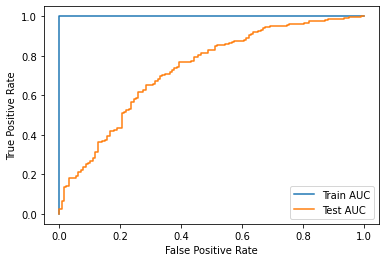

In [213]:
# calculate roc curves
tr_fpr, tr_tpr, _ = roc_curve(y_train, y_train_pred_proba)
te_fpr, te_tpr, _ = roc_curve(y_test, y_test_pred_proba)
# plot the roc curve for the model
plt.plot(tr_fpr, tr_tpr, label='Train AUC')
plt.plot(te_fpr, te_tpr, label='Test AUC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

- We have a descent test AUC score
- But there is a high gap between train and test. This means the model is  overfitting a lot.

__Classification Report__

In [214]:
print(classification_report(y_test, y_test_pred, target_names=['Do not churn', 'Churn']))

              precision    recall  f1-score   support

Do not churn       0.56      0.49      0.52       127
       Churn       0.80      0.85      0.82       314

    accuracy                           0.74       441
   macro avg       0.68      0.67      0.67       441
weighted avg       0.73      0.74      0.74       441



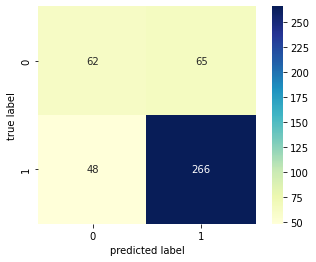

In [215]:
mat = confusion_matrix(y_test, y_test_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

- The RECALL for Churn class is good (0.85). 
- The PRECISION for Churn class is good as well (0.80).

## Summary

In [218]:
train_auc = np.around([model1_auc_train, model2_auc_train, model3_auc_train, \
             model4_auc_train, model5_auc_train, model6_auc_train], 3)
test_auc  = np.around([model1_auc_test, model2_auc_test, model3_auc_test, \
             model4_auc_test, model5_auc_test, model6_auc_test], 3)
delta     = np.around(np.array(train_auc) - np.array(test_auc), 3)

encoding = ['OHE', 'OHE', 'Target Encoding', 'Target Encoding',
            'Target Encoding', 'Target Encoding']
balance = ['None', 'None', 'None', 'None', 'SMOTE', 'SMOTE']

x = PrettyTable(["Model", "Train AUC", "Test AUC", "Delta", "Encoding", 'Balancing'])
i = 1
for a, b, c, d, e in zip(train_auc, test_auc, delta, encoding, balance):
    x.add_row(['Model '+str(i), a, b, c, d, e])
    x.add_row([' ', ' ', ' ', ' ', ' ', ' '])
    i += 1
print(x)

+---------+-----------+----------+-------+-----------------+-----------+
|  Model  | Train AUC | Test AUC | Delta |     Encoding    | Balancing |
+---------+-----------+----------+-------+-----------------+-----------+
| Model 1 |   0.808   |  0.694   | 0.114 |       OHE       |    None   |
|         |           |          |       |                 |           |
| Model 2 |   0.891   |  0.686   | 0.205 |       OHE       |    None   |
|         |           |          |       |                 |           |
| Model 3 |   0.879   |  0.784   | 0.095 | Target Encoding |    None   |
|         |           |          |       |                 |           |
| Model 4 |   0.963   |  0.764   | 0.199 | Target Encoding |    None   |
|         |           |          |       |                 |           |
| Model 5 |   0.959   |  0.741   | 0.218 | Target Encoding |   SMOTE   |
|         |           |          |       |                 |           |
| Model 6 |    1.0    |  0.732   | 0.268 | Target E

__Conclusions__
- Model 3 is the best model. The gap between train and test score is low, meaning the model generalizes well.
- Target Encoding was used to encode the categorical features in Model 3
- No class balancing was done for Model 3

- Class Imbalance did not improve the model as such. It only leads to overfitting

## Feature Importance Final Model

We'll look at the feature importance values for Model 3 and understand their predictive power:

In [219]:
top3 = pd.DataFrame({
    'Features': x_train.columns,
    'Coefficients': randf['randomforest'].feature_importances_
}).sort_values(by='Coefficients', ascending=False)
top3

,Features,Coefficients
10,rating_flag,0.346327
6,Grade,0.187860
2,City,0.142308
1,Gender,0.089537
4,Income,0.061115
0,Age,0.056697
8,Quarterly Rating,0.048776
9,income_flag,0.036915
7,Total Business Value,0.013506
3,Education_Level,0.008551


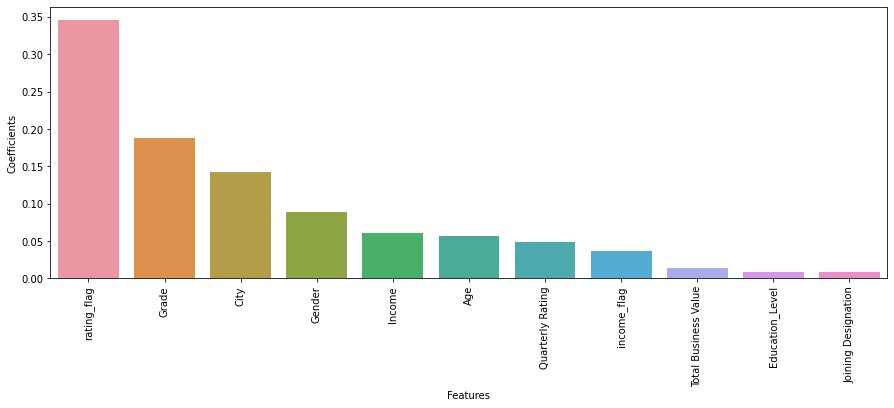

In [220]:
plt.figure(figsize=(15, 5))
sns.barplot(data=top3, x='Features', y='Coefficients')
plt.xticks(rotation=90)
plt.show()

__Insights__
- The higher the magnitude of the feature importance value, the more power it has to predict the Churn rate
- "rating_flag", "Grade", "City", "Gender", and "Income" are the top 5 most important feature
- 'Total Business Value', 'Education_Level", and "'Joining Designation" are the least important features


For better explainability of the dependent variable, we want the magnitude of coefficient values of the independent variables to be high. That means,  the larger the magnitude of coefficient is, higher is the impact of that feature on the dependent feature.

# Recommendations:



In [2]:
observations = [
    """Churn rate is high among Drivers whose Grades are low, and Quarterly 
    ratings do not increase over time.""",
    
    """The mean income of Drivers who churned is lower than those who have
    not churned.""" ,

    """The churn rate is similar for most of the cities but C20. The churn rate is very high for C20.""",

    """Male drivers churn more as compared to Female drivers"""
    ]


recommendations = [
    """The company should create some guidelines for
    the drivers. This will enable the driver to provide a better riding
    experience to the users, leading to increase in the driver Ratings.""",

    """The company should give better incentives to Drivers so they earn better incomes.""",

    """The company should try to understand the demography of cities like C20
    before launching its service. Functioning in an area with low demands
    is unprofitable for both the company and the drivers.""",

    """The company should provide attractive alternatives for Male drivers where their
    participation can be high. For instance, providing higher incentives for late night 
    rides where inclusion of Male drivers is expected to be high as compared to Female
    counterparts."""

    ]

x = PrettyTable(["Sl no", "Observations", "Recommendations"])
i = 1
for a, b in zip(observations, recommendations):
    x.add_row([i, a, b])
    x.add_row([' ', ' ', ' '])
    i += 1
print(x)

+-------+------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
| Sl no |                                          Observations                                          |                                     Recommendations                                      |
+-------+------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
|   1   |             Churn rate is high among Drivers whose Grades are low, and Quarterly               |                      The company should create some guidelines for                       |
|       |                                 ratings do not increase over time.                             |             the drivers. This will enable the driver to provide a better riding          |
|       | 